In [2]:
!pip install earthengine-api geemap ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.3 MB/s eta 0:00:00


In [3]:
EE_PROJECT = 'alpha-earth-473414'  # Replace with your GCP project ID

# Authenticate and initialize
ee.Authenticate()
ee.Initialize(project=EE_PROJECT)

In [7]:
"""
Global Canopy Height Visualization Tool - Simple Matplotlib Version
Converted from JavaScript to Python for Google Colab

This script downloads and visualizes global canopy height data using matplotlib
based on Tolan et al. (2023) research using sub-meter resolution canopy height maps.
"""

import ee
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import requests
from PIL import Image
import io


class CanopyHeightPlotter:
    """
    A class to download and plot Global Canopy Height data using matplotlib
    """

    def __init__(self):
        """Initialize the canopy height plotter with datasets"""

        print("Loading canopy height datasets...")

        # Load the main canopy height dataset from Meta/Facebook
        self.canopy_height = ee.ImageCollection("projects/sat-io/open-datasets/facebook/meta-canopy-height").mosaic()

        # Create a binary mask for areas with trees (>=1 meter height)
        self.tree_mask = self.canopy_height.updateMask(self.canopy_height.gte(1))

        # Load comparison datasets from other research teams
        # ETH Global Canopy Height (Lang et al. 2022) - 98th percentile, 10m resolution
        try:
            self.eth_canopy_height = ee.Image('users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1')
            print("ETH dataset loaded successfully")
        except:
            self.eth_canopy_height = None
            print("ETH dataset not accessible")

        # UMD GEDI-based canopy height (Potapov et al. 2021) - 95th percentile, 30m resolution
        try:
            self.umd_height = ee.ImageCollection("users/potapovpeter/GEDI_V27").mosaic()
            print("UMD dataset loaded successfully")
        except:
            self.umd_height = None
            print("UMD dataset not accessible")

        # Define the viridis-like color palette
        self.viridis_colors = ['#440154', '#482777', '#3f4a8a', '#31678e', '#26838f',
                              '#1f9d8a', '#6cce5a', '#b6de2b', '#fee825']

        print("Datasets loaded successfully!")

    def get_image_url(self, image, region, vis_params, width=1024, height=1024):
        """
        Generate a URL to download the image as a PNG

        Args:
            image: Earth Engine Image object
            region: Earth Engine Geometry object for the area of interest
            vis_params: Dictionary with visualization parameters (min, max, palette)
            width: Image width in pixels
            height: Image height in pixels

        Returns:
            URL string for downloading the image
        """

        url = image.getThumbURL({
            'region': region,
            'dimensions': f'{width}x{height}',
            'format': 'png',
            **vis_params
        })

        return url

    def download_and_plot_image(self, image, title, region=None, figsize=(12, 8)):
        """
        Download an Earth Engine image and plot it using matplotlib

        Args:
            image: Earth Engine Image object
            title: Title for the plot
            region: Earth Engine Geometry object (if None, uses global extent)
            figsize: Figure size tuple
        """

        # Define region if not provided (global extent)
        if region is None:
            region = ee.Geometry.Rectangle([-180, -60, 180, 85])  # Global extent excluding polar regions

        # Define visualization parameters
        vis_params = {
            'min': 0,
            'max': 25,
            'palette': self.viridis_colors
        }

        try:
            print(f"Generating URL for {title}...")

            # Get the image URL
            url = self.get_image_url(image, region, vis_params)

            print(f"Downloading image for {title}...")

            # Download the image
            response = requests.get(url)
            response.raise_for_status()

            # Open the image
            img = Image.open(io.BytesIO(response.content))
            img_array = np.array(img)

            # Plot the image
            plt.figure(figsize=figsize)
            plt.imshow(img_array, extent=[-180, 180, -60, 85])  # Set geographic extent
            plt.title(f'{title}\nCanopy Height (meters)', fontsize=14, fontweight='bold')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')

            # Add colorbar
            sm = plt.cm.ScalarMappable(cmap=self.create_viridis_colormap(),
                                     norm=plt.Normalize(vmin=0, vmax=25))
            sm.set_array([])
            cbar = plt.colorbar(sm, shrink=0.8, aspect=20)
            cbar.set_label('Canopy Height (meters)', rotation=270, labelpad=20)

            plt.tight_layout()
            plt.show()

            print(f"Successfully plotted {title}")

        except Exception as e:
            print(f"Error plotting {title}: {e}")

    def create_viridis_colormap(self):
        """Create a custom viridis-like colormap"""
        colors = ['#440154', '#482777', '#3f4a8a', '#31678e', '#26838f',
                 '#1f9d8a', '#6cce5a', '#b6de2b', '#fee825']
        n_bins = 256
        cmap = LinearSegmentedColormap.from_list('viridis', colors, N=n_bins)
        return cmap

    def plot_regional_comparison(self, region_name, bbox, figsize=(15, 10)):
        """
        Plot a comparison of different canopy height datasets for a specific region

        Args:
            region_name: Name of the region for the title
            bbox: Bounding box as [min_lon, min_lat, max_lon, max_lat]
            figsize: Figure size tuple
        """

        # Create region geometry
        region = ee.Geometry.Rectangle(bbox)

        # Create subplot figure
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        fig.suptitle(f'Canopy Height Comparison - {region_name}', fontsize=16, fontweight='bold')

        datasets = [
            (self.canopy_height, "Meta/Facebook (Tolan et al. 2023)\nSub-meter resolution"),
            (self.tree_mask, "Tree Areas (≥1m height)\nBinary classification"),
        ]

        # Add comparison datasets if available
        if self.eth_canopy_height is not None:
            datasets.append((self.eth_canopy_height, "ETH (Lang et al. 2022)\n98th percentile, 10m"))
        else:
            datasets.append((None, "ETH Dataset\nNot accessible"))

        if self.umd_height is not None:
            datasets.append((self.umd_height, "UMD (Potapov et al. 2021)\n95th percentile, 30m"))
        else:
            datasets.append((None, "UMD Dataset\nNot accessible"))

        for idx, (dataset, title) in enumerate(datasets):
            row = idx // 2
            col = idx % 2
            ax = axes[row, col]

            if dataset is not None:
                try:
                    # Special visualization for binary tree mask
                    if "Tree Areas" in title:
                        vis_params = {
                            'min': 0,
                            'max': 1,
                            'palette': ['#440154', '#fee825']  # Purple to yellow
                        }
                    else:
                        vis_params = {
                            'min': 0,
                            'max': 25,
                            'palette': self.viridis_colors
                        }

                    # Get image URL
                    url = dataset.getThumbURL({
                        'region': region,
                        'dimensions': '512x512',
                        'format': 'png',
                        **vis_params
                    })

                    # Download and display
                    response = requests.get(url)
                    response.raise_for_status()

                    img = Image.open(io.BytesIO(response.content))
                    img_array = np.array(img)

                    ax.imshow(img_array, extent=bbox)
                    ax.set_title(title, fontsize=10)
                    ax.set_xlabel('Longitude')
                    ax.set_ylabel('Latitude')

                except Exception as e:
                    ax.text(0.5, 0.5, f'Error loading:\n{str(e)[:50]}...',
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(title, fontsize=10)
            else:
                ax.text(0.5, 0.5, 'Dataset not\naccessible',
                       transform=ax.transAxes, ha='center', va='center')
                ax.set_title(title, fontsize=10)

        plt.tight_layout()
        plt.show()

    def analyze_point(self, lon, lat, buffer_size=1000):
        """
        Analyze canopy height at a specific point with a buffer

        Args:
            lon: Longitude
            lat: Latitude
            buffer_size: Buffer size in meters around the point
        """

        # Create point geometry with buffer
        point = ee.Geometry.Point([lon, lat]).buffer(buffer_size)

        print(f"Analyzing point: ({lon:.4f}, {lat:.4f}) with {buffer_size}m buffer")

        try:
            # Calculate statistics
            stats = self.canopy_height.reduceRegion(
                reducer=ee.Reducer.mean().combine(
                    reducer2=ee.Reducer.minMax(), sharedInputs=True
                ).combine(
                    reducer2=ee.Reducer.stdDev(), sharedInputs=True
                ),
                geometry=point,
                scale=30,
                maxPixels=1e9
            ).getInfo()

            # Extract values
            mean_height = stats.get('cover_code_mean', 'No data')
            min_height = stats.get('cover_code_min', 'No data')
            max_height = stats.get('cover_code_max', 'No data')
            std_height = stats.get('cover_code_stdDev', 'No data')

            print(f"Results for buffer area around ({lon:.4f}, {lat:.4f}):")
            print(f"  Mean height: {mean_height:.2f} meters" if isinstance(mean_height, (int, float)) else f"  Mean height: {mean_height}")
            print(f"  Height range: {min_height:.2f} - {max_height:.2f} meters" if isinstance(min_height, (int, float)) else f"  Height range: {min_height} - {max_height}")
            print(f"  Standard deviation: {std_height:.2f} meters" if isinstance(std_height, (int, float)) else f"  Standard deviation: {std_height}")

            # Create a small visualization of the area
            self.plot_small_area(lon, lat, buffer_size)

        except Exception as e:
            print(f"Error analyzing point: {e}")

    def plot_small_area(self, lon, lat, buffer_size):
        """Plot a small area around a specific point"""

        # Create slightly larger region for context
        buffer_deg = buffer_size / 111000  # Rough conversion to degrees
        bbox = [lon - buffer_deg*2, lat - buffer_deg*2,
                lon + buffer_deg*2, lat + buffer_deg*2]
        region = ee.Geometry.Rectangle(bbox)

        try:
            vis_params = {
                'min': 0,
                'max': 25,
                'palette': self.viridis_colors
            }

            url = self.canopy_height.getThumbURL({
                'region': region,
                'dimensions': '400x400',
                'format': 'png',
                **vis_params
            })

            response = requests.get(url)
            response.raise_for_status()

            img = Image.open(io.BytesIO(response.content))
            img_array = np.array(img)

            plt.figure(figsize=(8, 8))
            plt.imshow(img_array, extent=bbox)
            plt.plot(lon, lat, 'r*', markersize=15, label=f'Analysis point ({lon:.4f}, {lat:.4f})')
            plt.title(f'Canopy Height - Local Area\nBuffer: {buffer_size}m', fontweight='bold')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.legend()

            # Add colorbar
            sm = plt.cm.ScalarMappable(cmap=self.create_viridis_colormap(),
                                     norm=plt.Normalize(vmin=0, vmax=25))
            sm.set_array([])
            cbar = plt.colorbar(sm, shrink=0.8)
            cbar.set_label('Canopy Height (m)', rotation=270, labelpad=15)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not create local area plot: {e}")


# Helper functions for common regions
def get_predefined_regions():
    """Return a dictionary of predefined regions with their bounding boxes"""

    regions = {
        'Amazon Rainforest': [-75, -10, -50, 5],
        'Congo Basin': [10, -5, 30, 5],
        'Indonesian Forests': [95, -10, 140, 10],
        'North American Forests': [-130, 30, -60, 60],
        'European Forests': [-10, 35, 40, 70],
        'Global Overview': [-180, -60, 180, 85]
    }

    return regions


# Example usage functions
def plot_global_overview():
    """Plot a global overview of canopy height"""
    plotter = CanopyHeightPlotter()
    plotter.download_and_plot_image(
        plotter.canopy_height,
        "Global Canopy Height Overview",
        figsize=(16, 10)
    )

def plot_region_comparison(region_name='Amazon Rainforest'):
    """Plot a comparison of datasets for a specific region"""
    plotter = CanopyHeightPlotter()
    regions = get_predefined_regions()

    if region_name in regions:
        bbox = regions[region_name]
        plotter.plot_regional_comparison(region_name, bbox)
    else:
        print(f"Region '{region_name}' not found. Available regions:")
        for name in regions.keys():
            print(f"  - {name}")

def analyze_location(lon, lat, buffer_size=1000):
    """Analyze canopy height at a specific location"""
    plotter = CanopyHeightPlotter()
    plotter.analyze_point(lon, lat, buffer_size)

def main_demo():
    """Run a demonstration of the canopy height plotter"""

    print("="*60)
    print("GLOBAL CANOPY HEIGHT PLOTTER - DEMONSTRATION")
    print("="*60)

    # Create plotter instance
    plotter = CanopyHeightPlotter()

    print("\n1. Plotting Global Overview...")
    plotter.download_and_plot_image(
        plotter.canopy_height,
        "Global Canopy Height Overview (Meta/Facebook Dataset)",
        figsize=(16, 8)
    )

    print("\n2. Plotting Amazon Rainforest Comparison...")
    regions = get_predefined_regions()
    plotter.plot_regional_comparison('Amazon Rainforest', regions['Amazon Rainforest'])

    print("\n3. Analyzing specific location (Amazon)...")
    # Coordinates in the Amazon rainforest
    plotter.analyze_point(-60.0, -3.0, buffer_size=5000)

    print("\n4. Creating custom colorbar legend...")
    create_colorbar_legend(plotter)

    return plotter

def create_colorbar_legend(plotter):
    """Create a standalone colorbar legend"""

    fig, ax = plt.subplots(figsize=(10, 2))

    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=plotter.create_viridis_colormap(),
                             norm=plt.Normalize(vmin=0, vmax=25))
    sm.set_array([])

    cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', shrink=0.8)
    cbar.set_label('Canopy Height (meters)', fontsize=12)
    cbar.ax.tick_params(labelsize=10)

    ax.remove()  # Remove the axes, keep only colorbar

    plt.title('Global Canopy Height Color Scale\n(Tolan et al. 2023 - Meta/Facebook Dataset)',
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


# Quick start examples
print("\n" + "="*60)
print("QUICK START EXAMPLES:")
print("="*60)
print("\n1. For global overview:")
print("   plot_global_overview()")
print("\n2. For regional comparison:")
print("   plot_region_comparison('Amazon Rainforest')")
print("\n3. For point analysis:")
print("   analyze_location(-60.0, -3.0)  # Amazon coordinates")
print("\n4. For full demonstration:")
print("   demo_plotter = main_demo()")
print("\n5. Available regions:")
for region in get_predefined_regions().keys():
    print(f"   - {region}")


QUICK START EXAMPLES:

1. For global overview:
   plot_global_overview()

2. For regional comparison:
   plot_region_comparison('Amazon Rainforest')

3. For point analysis:
   analyze_location(-60.0, -3.0)  # Amazon coordinates

4. For full demonstration:
   demo_plotter = main_demo()

5. Available regions:
   - Amazon Rainforest
   - Congo Basin
   - Indonesian Forests
   - North American Forests
   - European Forests
   - Global Overview


Loading canopy height datasets...
ETH dataset loaded successfully
UMD dataset loaded successfully
Datasets loaded successfully!


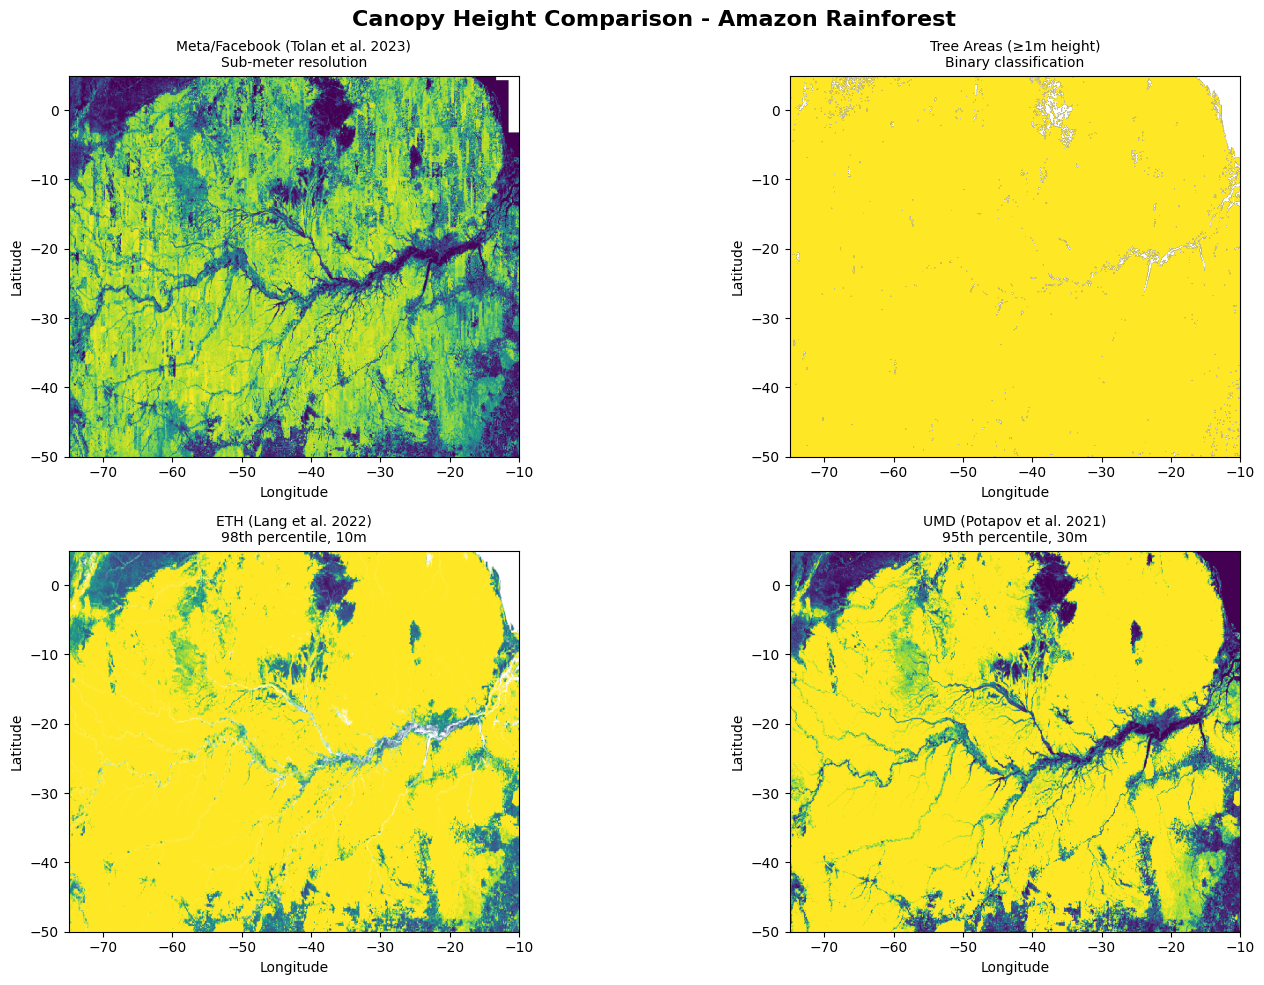

In [8]:
plot_region_comparison('Amazon Rainforest')

Loading canopy height datasets...
ETH dataset loaded successfully
UMD dataset loaded successfully
Datasets loaded successfully!
Analyzing point: (-60.0000, -3.0000) with 5000m buffer
Results for buffer area around (-60.0000, -3.0000):
  Mean height: 4.66 meters
  Height range: 0.00 - 30.00 meters
  Standard deviation: 7.38 meters
Could not create local area plot: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


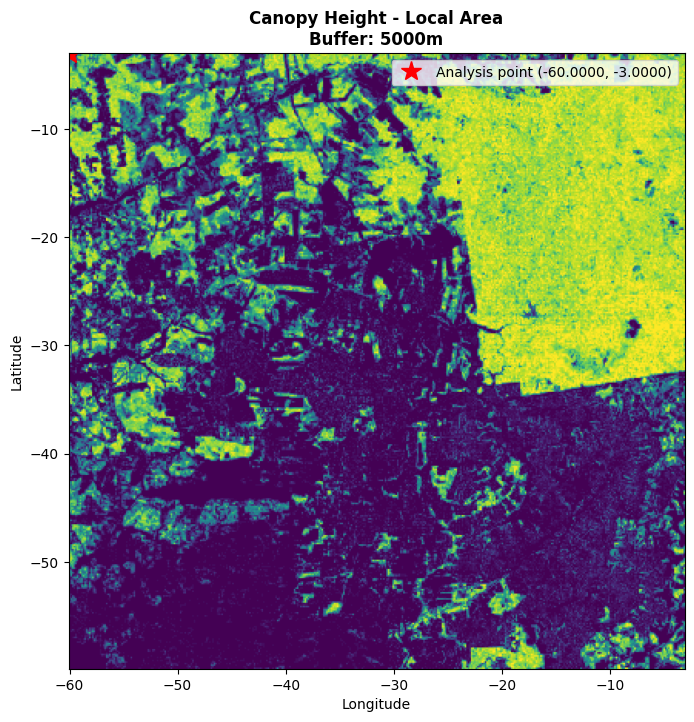

In [9]:
analyze_location(-60.0, -3.0, buffer_size=5000)  # Amazon rainforest coordinates

In [13]:
"""
Earth Engine Dataset Explorer
Lists and displays information about available datasets in Google Earth Engine

This script helps explore and discover datasets available in Earth Engine,
particularly focusing on forest/vegetation datasets.
"""

import ee
import pandas as pd
from datetime import datetime
import json

# Initialize Earth Engine with your project ID
try:
    ee.Initialize(project='alpha-earth-473414')
    print("Earth Engine initialized successfully!")
except Exception as e:
    print(f"Error initializing Earth Engine: {e}")
    print("Please authenticate first using: ee.Authenticate()")

class EarthEngineDatasetExplorer:
    """
    A class to explore and list available Earth Engine datasets
    """

    def __init__(self):
        """Initialize the dataset explorer"""
        self.known_datasets = self.get_known_datasets()

    def get_known_datasets(self):
        """
        Return a comprehensive list of known Earth Engine datasets
        organized by category
        """

        datasets = {
            'Forest/Canopy Height': {
                'projects/sat-io/open-datasets/facebook/meta-canopy-height': {
                    'name': 'Meta Global Canopy Height',
                    'description': 'Sub-meter resolution global canopy height maps',
                    'reference': 'Tolan et al. (2023)',
                    'resolution': 'Sub-meter (~1m)',
                    'temporal_coverage': '2020',
                    'type': 'ImageCollection',
                    'provider': 'Meta/Facebook'
                },
                'users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1': {
                    'name': 'ETH Global Canopy Height',
                    'description': 'Global canopy height at 10m resolution',
                    'reference': 'Lang et al. (2022)',
                    'resolution': '10m',
                    'temporal_coverage': '2020',
                    'type': 'Image',
                    'provider': 'ETH Zurich'
                },
                'users/potapovpeter/GEDI_V27': {
                    'name': 'UMD GEDI Canopy Height',
                    'description': 'GEDI-based global canopy height',
                    'reference': 'Potapov et al. (2021)',
                    'resolution': '30m',
                    'temporal_coverage': '2019-2020',
                    'type': 'ImageCollection',
                    'provider': 'University of Maryland'
                }
            },

            'Forest Cover/Loss': {
                'UMD/hansen/global_forest_change_2023_v1_11': {
                    'name': 'Hansen Global Forest Change',
                    'description': 'Global forest cover, loss, and gain',
                    'reference': 'Hansen et al. (2013)',
                    'resolution': '30m',
                    'temporal_coverage': '2000-2023',
                    'type': 'Image',
                    'provider': 'University of Maryland'
                },
                'JAXA/ALOS/PALSAR/YEARLY/FNF': {
                    'name': 'JAXA PALSAR Forest/Non-Forest',
                    'description': 'Annual forest/non-forest maps',
                    'reference': 'JAXA EORC',
                    'resolution': '25m',
                    'temporal_coverage': '2007-2020',
                    'type': 'ImageCollection',
                    'provider': 'JAXA'
                }
            },

            'Vegetation Indices': {
                'MODIS/061/MOD13Q1': {
                    'name': 'MODIS NDVI 16-Day',
                    'description': '16-day composite NDVI at 250m resolution',
                    'reference': 'MODIS Collection 6.1',
                    'resolution': '250m',
                    'temporal_coverage': '2000-present',
                    'type': 'ImageCollection',
                    'provider': 'NASA'
                },
                'LANDSAT/LC08/C02/T1_L2': {
                    'name': 'Landsat 8 Surface Reflectance',
                    'description': 'Landsat 8 atmospherically corrected surface reflectance',
                    'reference': 'USGS Landsat',
                    'resolution': '30m',
                    'temporal_coverage': '2013-present',
                    'type': 'ImageCollection',
                    'provider': 'USGS'
                }
            },

            'Climate/Weather': {
                'ECMWF/ERA5_LAND/DAILY_AGGR': {
                    'name': 'ERA5-Land Daily Aggregated',
                    'description': 'Daily aggregated ERA5-Land reanalysis data',
                    'reference': 'Copernicus Climate Change Service',
                    'resolution': '11132m',
                    'temporal_coverage': '1950-present',
                    'type': 'ImageCollection',
                    'provider': 'ECMWF'
                },
                'NASA/GPM_L3/IMERG_V07': {
                    'name': 'GPM Precipitation',
                    'description': 'Global Precipitation Measurement mission data',
                    'reference': 'NASA GPM',
                    'resolution': '11132m',
                    'temporal_coverage': '2000-present',
                    'type': 'ImageCollection',
                    'provider': 'NASA'
                }
            },

            'Land Cover': {
                'ESA/WorldCover/v200': {
                    'name': 'ESA WorldCover',
                    'description': 'Global land cover at 10m resolution',
                    'reference': 'ESA WorldCover (2021)',
                    'resolution': '10m',
                    'temporal_coverage': '2020-2021',
                    'type': 'ImageCollection',
                    'provider': 'European Space Agency'
                },
                'COPERNICUS/Landcover/100m/Proba-V-C3/Global': {
                    'name': 'Copernicus Land Cover',
                    'description': 'Global land cover at 100m resolution',
                    'reference': 'Copernicus Global Land Service',
                    'resolution': '100m',
                    'temporal_coverage': '2015-2019',
                    'type': 'ImageCollection',
                    'provider': 'Copernicus'
                }
            },

            'Topography': {
                'NASA/NASADEM_HGT/001': {
                    'name': 'NASADEM Elevation',
                    'description': 'NASA Digital Elevation Model',
                    'reference': 'NASA JPL (2020)',
                    'resolution': '30m',
                    'temporal_coverage': 'February 2000',
                    'type': 'Image',
                    'provider': 'NASA JPL'
                },
                'JAXA/ALOS/AW3D30/V3_2': {
                    'name': 'ALOS World 3D',
                    'description': 'Global digital surface model',
                    'reference': 'JAXA EORC',
                    'resolution': '30m',
                    'temporal_coverage': '2006-2011',
                    'type': 'Image',
                    'provider': 'JAXA'
                }
            }
        }

        return datasets

    def list_all_datasets(self):
        """
        Display all known datasets in a formatted table
        """

        print("="*80)
        print("EARTH ENGINE DATASET CATALOG")
        print("="*80)

        all_data = []

        for category, datasets in self.known_datasets.items():
            print(f"\n📁 {category.upper()}")
            print("-" * 60)

            for dataset_id, info in datasets.items():
                print(f"\n🔹 {info['name']}")
                print(f"   ID: {dataset_id}")
                print(f"   Description: {info['description']}")
                print(f"   Provider: {info['provider']}")
                print(f"   Resolution: {info['resolution']}")
                print(f"   Coverage: {info['temporal_coverage']}")
                print(f"   Type: {info['type']}")
                print(f"   Reference: {info['reference']}")

                # Add to list for DataFrame
                all_data.append({
                    'Category': category,
                    'Name': info['name'],
                    'Dataset_ID': dataset_id,
                    'Provider': info['provider'],
                    'Resolution': info['resolution'],
                    'Coverage': info['temporal_coverage'],
                    'Type': info['type'],
                    'Description': info['description'][:50] + "..." if len(info['description']) > 50 else info['description']
                })

        return pd.DataFrame(all_data)

    def check_dataset_availability(self, dataset_id):
        """
        Check if a specific dataset is available and get its properties

        Args:
            dataset_id: Earth Engine dataset ID
        """

        print(f"\nChecking dataset: {dataset_id}")
        print("-" * 50)

        try:
            # Try to load as ImageCollection first
            try:
                collection = ee.ImageCollection(dataset_id)
                size = collection.size().getInfo()

                if size > 0:
                    # Get first image to check properties
                    first_image = collection.first()
                    info = first_image.getInfo()

                    print(f"✅ Dataset available as ImageCollection")
                    print(f"   Number of images: {size}")
                    print(f"   Image properties: {len(info['properties'])} properties")

                    # Get date range if available
                    try:
                        date_range = collection.reduceColumns(
                            ee.Reducer.minMax(),
                            ['system:time_start']
                        ).getInfo()

                        if 'min' in date_range and 'max' in date_range:
                            start_date = datetime.fromtimestamp(date_range['min'] / 1000).strftime('%Y-%m-%d')
                            end_date = datetime.fromtimestamp(date_range['max'] / 1000).strftime('%Y-%m-%d')
                            print(f"   Date range: {start_date} to {end_date}")
                    except:
                        print("   Date range: Not available")

                    # Get band information
                    band_names = first_image.bandNames().getInfo()
                    print(f"   Bands: {band_names}")

                    return {
                        'type': 'ImageCollection',
                        'available': True,
                        'size': size,
                        'bands': band_names,
                        'properties': info['properties']
                    }

            except:
                # Try as Image
                image = ee.Image(dataset_id)
                info = image.getInfo()

                print(f"✅ Dataset available as Image")
                print(f"   Image properties: {len(info['properties'])} properties")

                # Get band information
                band_names = image.bandNames().getInfo()
                print(f"   Bands: {band_names}")

                return {
                    'type': 'Image',
                    'available': True,
                    'bands': band_names,
                    'properties': info['properties']
                }

        except Exception as e:
            print(f"❌ Dataset not available or accessible")
            print(f"   Error: {str(e)}")
            return {
                'type': 'Unknown',
                'available': False,
                'error': str(e)
            }

    def check_all_datasets(self):
        """
        Check availability of all known datasets
        """

        print("\n" + "="*80)
        print("DATASET AVAILABILITY CHECK")
        print("="*80)

        results = {}

        for category, datasets in self.known_datasets.items():
            print(f"\n📂 Checking {category}...")
            results[category] = {}

            for dataset_id, info in datasets.items():
                print(f"\n🔍 {info['name']}")
                result = self.check_dataset_availability(dataset_id)
                results[category][dataset_id] = {
                    'info': info,
                    'status': result
                }

        return results

    def get_dataset_sample(self, dataset_id, sample_point=None):
        """
        Get a sample value from a dataset at a specific point

        Args:
            dataset_id: Earth Engine dataset ID
            sample_point: [longitude, latitude] coordinates (default: Amazon rainforest)
        """

        if sample_point is None:
            sample_point = [-60.0, -3.0]  # Amazon rainforest

        point = ee.Geometry.Point(sample_point)

        print(f"\nSampling dataset at point: {sample_point}")
        print(f"Dataset: {dataset_id}")

        try:
            # Try as ImageCollection first
            try:
                collection = ee.ImageCollection(dataset_id)
                # Get the most recent image
                image = collection.sort('system:time_start', False).first()
            except:
                # Try as Image
                image = ee.Image(dataset_id)

            # Sample the image
            sample = image.sample(
                region=point,
                scale=30,
                numPixels=1
            ).first()

            properties = sample.getInfo()['properties']

            print("Sample values:")
            for band, value in properties.items():
                if band.startswith('system:'):
                    continue
                print(f"  {band}: {value}")

            return properties

        except Exception as e:
            print(f"Error sampling dataset: {e}")
            return None

    def search_datasets(self, keyword):
        """
        Search for datasets containing a specific keyword

        Args:
            keyword: Search term (case-insensitive)
        """

        print(f"\n🔍 Searching for datasets containing: '{keyword}'")
        print("-" * 50)

        keyword = keyword.lower()
        found_datasets = []

        for category, datasets in self.known_datasets.items():
            for dataset_id, info in datasets.items():
                # Search in name, description, and dataset_id
                searchable_text = f"{info['name']} {info['description']} {dataset_id}".lower()

                if keyword in searchable_text:
                    found_datasets.append({
                        'category': category,
                        'dataset_id': dataset_id,
                        'info': info
                    })

        if found_datasets:
            print(f"Found {len(found_datasets)} matching datasets:")

            for dataset in found_datasets:
                print(f"\n📊 {dataset['info']['name']}")
                print(f"   Category: {dataset['category']}")
                print(f"   ID: {dataset['dataset_id']}")
                print(f"   Description: {dataset['info']['description']}")
                print(f"   Provider: {dataset['info']['provider']}")
        else:
            print("No datasets found matching the search term.")

        return found_datasets

    def get_popular_collections(self):
        """
        List some popular Earth Engine collections beyond our known list
        """

        popular_collections = {
            'Sentinel-2': 'COPERNICUS/S2_SR_HARMONIZED',
            'Sentinel-1': 'COPERNICUS/S1_GRD',
            'Landsat 9': 'LANDSAT/LC09/C02/T1_L2',
            'MODIS Terra Daily': 'MODIS/061/MOD09GA',
            'SRTM Elevation': 'CGIAR/SRTM90_V4',
            'Global Population': 'CIESIN/GPWv411/GPW_Population_Density',
            'Night Lights': 'NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG',
            'Global Surface Water': 'JRC/GSW1_4/GlobalSurfaceWater'
        }

        print("\n🌟 POPULAR EARTH ENGINE COLLECTIONS")
        print("=" * 50)

        for name, collection_id in popular_collections.items():
            print(f"\n📡 {name}")
            print(f"   ID: {collection_id}")
            self.check_dataset_availability(collection_id)


# Usage functions
def explore_all_datasets():
    """Explore all datasets and return a summary DataFrame"""
    explorer = EarthEngineDatasetExplorer()
    return explorer.list_all_datasets()

def check_dataset_status():
    """Check the availability of all known datasets"""
    explorer = EarthEngineDatasetExplorer()
    return explorer.check_all_datasets()

def search_for_datasets(keyword):
    """Search for datasets by keyword"""
    explorer = EarthEngineDatasetExplorer()
    return explorer.search_datasets(keyword)

def sample_dataset(dataset_id, coordinates=None):
    """Sample a dataset at specific coordinates"""
    explorer = EarthEngineDatasetExplorer()
    return explorer.get_dataset_sample(dataset_id, coordinates)

def show_popular_collections():
    """Show popular Earth Engine collections"""
    explorer = EarthEngineDatasetExplorer()
    explorer.get_popular_collections()

# Main execution
def main():
    """
    Main function to demonstrate the dataset explorer
    """

    print("🌍 Earth Engine Dataset Explorer")
    print("=" * 50)

    explorer = EarthEngineDatasetExplorer()

    # Show all datasets
    df = explorer.list_all_datasets()

    print(f"\n📊 Total datasets cataloged: {len(df)}")
    print(f"📂 Categories: {df['Category'].nunique()}")

    return df, explorer

# Quick commands for users
print("\n" + "="*60)
print("QUICK COMMANDS:")
print("="*60)
print("1. View all datasets:")
print("   df, explorer = main()")
print("\n2. Check dataset availability:")
print("   results = check_dataset_status()")
print("\n3. Search for specific datasets:")
print("   search_for_datasets('forest')")
print("\n4. Sample a dataset:")
print("   sample_dataset('projects/sat-io/open-datasets/facebook/meta-canopy-height')")
print("\n5. Show popular collections:")
print("   show_popular_collections()")

Earth Engine initialized successfully!

QUICK COMMANDS:
1. View all datasets:
   df, explorer = main()

2. Check dataset availability:
   results = check_dataset_status()

3. Search for specific datasets:
   search_for_datasets('forest')

4. Sample a dataset:
   sample_dataset('projects/sat-io/open-datasets/facebook/meta-canopy-height')

5. Show popular collections:
   show_popular_collections()


In [14]:
df, explorer = main()

🌍 Earth Engine Dataset Explorer
EARTH ENGINE DATASET CATALOG

📁 FOREST/CANOPY HEIGHT
------------------------------------------------------------

🔹 Meta Global Canopy Height
   ID: projects/sat-io/open-datasets/facebook/meta-canopy-height
   Description: Sub-meter resolution global canopy height maps
   Provider: Meta/Facebook
   Resolution: Sub-meter (~1m)
   Coverage: 2020
   Type: ImageCollection
   Reference: Tolan et al. (2023)

🔹 ETH Global Canopy Height
   ID: users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1
   Description: Global canopy height at 10m resolution
   Provider: ETH Zurich
   Resolution: 10m
   Coverage: 2020
   Type: Image
   Reference: Lang et al. (2022)

🔹 UMD GEDI Canopy Height
   ID: users/potapovpeter/GEDI_V27
   Description: GEDI-based global canopy height
   Provider: University of Maryland
   Resolution: 30m
   Coverage: 2019-2020
   Type: ImageCollection
   Reference: Potapov et al. (2021)

📁 FOREST COVER/LOSS
-----------------------------------------------

In [15]:
# Search for forest-related datasets
search_for_datasets('forest')

# Search for canopy datasets
search_for_datasets('canopy')

# Search for elevation data
search_for_datasets('elevation')


🔍 Searching for datasets containing: 'forest'
--------------------------------------------------
Found 2 matching datasets:

📊 Hansen Global Forest Change
   Category: Forest Cover/Loss
   ID: UMD/hansen/global_forest_change_2023_v1_11
   Description: Global forest cover, loss, and gain
   Provider: University of Maryland

📊 JAXA PALSAR Forest/Non-Forest
   Category: Forest Cover/Loss
   ID: JAXA/ALOS/PALSAR/YEARLY/FNF
   Description: Annual forest/non-forest maps
   Provider: JAXA

🔍 Searching for datasets containing: 'canopy'
--------------------------------------------------
Found 3 matching datasets:

📊 Meta Global Canopy Height
   Category: Forest/Canopy Height
   ID: projects/sat-io/open-datasets/facebook/meta-canopy-height
   Description: Sub-meter resolution global canopy height maps
   Provider: Meta/Facebook

📊 ETH Global Canopy Height
   Category: Forest/Canopy Height
   ID: users/nlang/ETH_GlobalCanopyHeight_2020_10m_v1
   Description: Global canopy height at 10m resolutio

[{'category': 'Topography',
  'dataset_id': 'NASA/NASADEM_HGT/001',
  'info': {'name': 'NASADEM Elevation',
   'description': 'NASA Digital Elevation Model',
   'reference': 'NASA JPL (2020)',
   'resolution': '30m',
   'temporal_coverage': 'February 2000',
   'type': 'Image',
   'provider': 'NASA JPL'}}]

In [16]:
"""
Forest Cover and Deforestation Analysis Tool
Using Google Earth Engine for forest monitoring and change detection

This script focuses on:
1. Hansen Global Forest Change (2000-2023) - Forest cover, loss, gain
2. JAXA PALSAR Forest/Non-Forest maps
3. Forest cover percentage analysis
4. Deforestation hotspot identification
5. Time series analysis of forest loss
"""

import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import requests
from PIL import Image
import io

# Initialize Earth Engine
try:
    ee.Initialize(project='alpha-earth-473414')
    print("Earth Engine initialized successfully!")
except Exception as e:
    print(f"Error initializing Earth Engine: {e}")
    print("Please authenticate first using: ee.Authenticate()")

class ForestCoverAnalyzer:
    """
    Analyze forest cover and deforestation using Earth Engine datasets
    """

    def __init__(self):
        """Initialize the forest cover analyzer with key datasets"""

        print("Loading forest datasets...")

        # Hansen Global Forest Change (most comprehensive)
        self.hansen = ee.Image('UMD/hansen/global_forest_change_2023_v1_11')

        # JAXA PALSAR Forest/Non-Forest (alternative dataset)
        try:
            self.jaxa_fnf = ee.ImageCollection('JAXA/ALOS/PALSAR/YEARLY/FNF')
            print("JAXA PALSAR dataset loaded")
        except:
            self.jaxa_fnf = None
            print("JAXA PALSAR dataset not accessible")

        # ESA WorldCover for recent forest cover
        try:
            self.esa_worldcover = ee.ImageCollection('ESA/WorldCover/v200')
            print("ESA WorldCover dataset loaded")
        except:
            self.esa_worldcover = None
            print("ESA WorldCover dataset not accessible")

        print("Forest datasets ready!")

    def get_hansen_bands_info(self):
        """
        Display information about Hansen dataset bands
        """

        print("\n📊 HANSEN GLOBAL FOREST CHANGE DATASET")
        print("=" * 60)
        print("Dataset ID: UMD/hansen/global_forest_change_2023_v1_11")
        print("Reference: Hansen et al. (2013), updated annually")
        print("Resolution: 30 meters")
        print("Coverage: Global, 2000-2023")

        bands_info = {
            'treecover2000': {
                'description': 'Tree canopy cover percentage in year 2000',
                'values': '0-100 (percentage)',
                'use': 'Baseline forest cover'
            },
            'loss': {
                'description': 'Forest loss during 2000-2023',
                'values': '0 = no loss, 1 = loss occurred',
                'use': 'Identify deforested areas'
            },
            'gain': {
                'description': 'Forest gain during 2000-2012',
                'values': '0 = no gain, 1 = gain occurred',
                'use': 'Identify reforested areas'
            },
            'lossyear': {
                'description': 'Year of forest loss',
                'values': '0 = no loss, 1-23 = year since 2000',
                'use': 'When deforestation happened'
            },
            'first': {
                'description': 'First year with >50% tree cover',
                'values': '0-23 (years since 2000)',
                'use': 'Forest establishment timing'
            },
            'last': {
                'description': 'Last year with >50% tree cover',
                'values': '0-23 (years since 2000)',
                'use': 'Forest persistence'
            }
        }

        print("\n📋 Available Bands:")
        for band, info in bands_info.items():
            print(f"\n🔹 {band}")
            print(f"   Description: {info['description']}")
            print(f"   Values: {info['values']}")
            print(f"   Use case: {info['use']}")

        return bands_info

    def analyze_forest_cover_region(self, region_name, bbox, year=2000, min_tree_cover=30):
        """
        Analyze forest cover for a specific region

        Args:
            region_name: Name of the region
            bbox: [min_lon, min_lat, max_lon, max_lat]
            year: Year for analysis (2000 for baseline)
            min_tree_cover: Minimum tree cover percentage to consider as forest
        """

        print(f"\n🌲 FOREST COVER ANALYSIS: {region_name}")
        print("=" * 60)

        # Create region geometry
        region = ee.Geometry.Rectangle(bbox)

        # Get tree cover for the specified year
        if year == 2000:
            tree_cover = self.hansen.select('treecover2000')
        else:
            print("Note: Hansen baseline is 2000. Using 2000 data.")
            tree_cover = self.hansen.select('treecover2000')

        # Create forest mask (areas with >= min_tree_cover)
        forest_mask = tree_cover.gte(min_tree_cover)

        try:
            # Calculate statistics
            stats = tree_cover.reduceRegion(
                reducer=ee.Reducer.mean().combine(
                    reducer2=ee.Reducer.minMax(), sharedInputs=True
                ).combine(
                    reducer2=ee.Reducer.stdDev(), sharedInputs=True
                ),
                geometry=region,
                scale=1000,  # 1km resolution for regional analysis
                maxPixels=1e9
            ).getInfo()

            # Calculate forest area
            forest_area = forest_mask.multiply(ee.Image.pixelArea()).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=1000,
                maxPixels=1e9
            ).getInfo()

            # Calculate total area
            total_area = ee.Image.pixelArea().reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=1000,
                maxPixels=1e9
            ).getInfo()

            # Extract values
            mean_cover = stats.get('treecover2000_mean', 0)
            min_cover = stats.get('treecover2000_min', 0)
            max_cover = stats.get('treecover2000_max', 0)
            std_cover = stats.get('treecover2000_stdDev', 0)

            forest_area_km2 = forest_area.get('treecover2000', 0) / 1e6  # Convert to km²
            total_area_km2 = total_area.get('area', 1) / 1e6
            forest_percentage = (forest_area_km2 / total_area_km2) * 100

            # Print results
            print(f"Region: {region_name}")
            print(f"Bounding box: {bbox}")
            print(f"Analysis year: {year}")
            print(f"Forest threshold: ≥{min_tree_cover}% tree cover")
            print("\n📊 RESULTS:")
            print(f"  Total area: {total_area_km2:,.0f} km²")
            print(f"  Forest area: {forest_area_km2:,.0f} km²")
            print(f"  Forest coverage: {forest_percentage:.1f}%")
            print(f"\n📈 TREE COVER STATISTICS:")
            print(f"  Mean tree cover: {mean_cover:.1f}%")
            print(f"  Range: {min_cover:.1f}% - {max_cover:.1f}%")
            print(f"  Standard deviation: {std_cover:.1f}%")

            # Create visualization
            self.visualize_forest_cover(region_name, region, tree_cover, forest_mask, bbox)

            return {
                'region_name': region_name,
                'total_area_km2': total_area_km2,
                'forest_area_km2': forest_area_km2,
                'forest_percentage': forest_percentage,
                'mean_tree_cover': mean_cover,
                'stats': stats
            }

        except Exception as e:
            print(f"Error analyzing region: {e}")
            return None

    def analyze_deforestation(self, region_name, bbox, start_year=2001, end_year=2023):
        """
        Analyze deforestation patterns in a region

        Args:
            region_name: Name of the region
            bbox: [min_lon, min_lat, max_lon, max_lat]
            start_year: Start year for analysis
            end_year: End year for analysis
        """

        print(f"\n🔥 DEFORESTATION ANALYSIS: {region_name}")
        print("=" * 60)

        # Create region geometry
        region = ee.Geometry.Rectangle(bbox)

        try:
            # Get forest loss and loss year
            loss = self.hansen.select('loss')
            loss_year = self.hansen.select('lossyear')
            tree_cover_2000 = self.hansen.select('treecover2000')

            # Filter loss by year range
            year_mask = loss_year.gte(start_year - 2000).And(loss_year.lte(end_year - 2000))
            filtered_loss = loss.updateMask(year_mask)

            # Calculate total forest loss area
            loss_area = filtered_loss.multiply(ee.Image.pixelArea()).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=1000,
                maxPixels=1e9
            ).getInfo()

            # Calculate original forest area (2000)
            original_forest = tree_cover_2000.gte(30)  # 30% threshold
            original_forest_area = original_forest.multiply(ee.Image.pixelArea()).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=1000,
                maxPixels=1e9
            ).getInfo()

            # Extract values
            loss_area_km2 = loss_area.get('loss', 0) / 1e6
            original_area_km2 = original_forest_area.get('treecover2000', 1) / 1e6
            loss_percentage = (loss_area_km2 / original_area_km2) * 100

            print(f"Period: {start_year}-{end_year}")
            print(f"Region: {region_name}")
            print(f"\n🔥 DEFORESTATION RESULTS:")
            print(f"  Original forest area (2000): {original_area_km2:,.0f} km²")
            print(f"  Forest loss area: {loss_area_km2:,.0f} km²")
            print(f"  Forest loss percentage: {loss_percentage:.2f}%")
            print(f"  Annual loss rate: {loss_percentage/(end_year-start_year+1):.3f}%/year")

            # Analyze year-by-year loss
            yearly_loss = self.get_yearly_loss(region, start_year, end_year)

            # Create visualizations
            self.visualize_deforestation(region_name, region, loss, loss_year, bbox, start_year, end_year)
            self.plot_yearly_loss(region_name, yearly_loss)

            return {
                'region_name': region_name,
                'period': f"{start_year}-{end_year}",
                'original_forest_km2': original_area_km2,
                'loss_km2': loss_area_km2,
                'loss_percentage': loss_percentage,
                'annual_rate': loss_percentage/(end_year-start_year+1),
                'yearly_loss': yearly_loss
            }

        except Exception as e:
            print(f"Error analyzing deforestation: {e}")
            return None

    def get_yearly_loss(self, region, start_year, end_year):
        """Get forest loss for each year"""

        yearly_data = []
        loss = self.hansen.select('loss')
        loss_year = self.hansen.select('lossyear')

        for year in range(start_year, end_year + 1):
            try:
                # Create mask for this specific year
                year_mask = loss_year.eq(year - 2000)
                year_loss = loss.updateMask(year_mask)

                # Calculate area for this year
                area = year_loss.multiply(ee.Image.pixelArea()).reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=region,
                    scale=1000,
                    maxPixels=1e9
                ).getInfo()

                area_km2 = area.get('loss', 0) / 1e6
                yearly_data.append({'year': year, 'loss_km2': area_km2})

            except:
                yearly_data.append({'year': year, 'loss_km2': 0})

        return yearly_data

    def visualize_forest_cover(self, region_name, region, tree_cover, forest_mask, bbox):
        """Visualize forest cover"""

        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

            # Tree cover percentage
            vis_params1 = {
                'min': 0,
                'max': 100,
                'palette': ['#ffffcc', '#a1dab4', '#41b6c4', '#2c7fb8', '#253494']
            }

            url1 = tree_cover.getThumbURL({
                'region': region,
                'dimensions': '500x500',
                'format': 'png',
                'crs': 'EPSG:4326',
                **vis_params1
            })

            response1 = requests.get(url1)
            img1 = Image.open(io.BytesIO(response1.content))

            ax1.imshow(np.array(img1), extent=bbox)
            ax1.set_title(f'{region_name}\nTree Cover Percentage (2000)', fontweight='bold')
            ax1.set_xlabel('Longitude')
            ax1.set_ylabel('Latitude')

            # Forest/non-forest binary
            vis_params2 = {
                'min': 0,
                'max': 1,
                'palette': ['#ffffff', '#00ff00']
            }

            url2 = forest_mask.getThumbURL({
                'region': region,
                'dimensions': '500x500',
                'format': 'png',
                'crs': 'EPSG:4326',
                **vis_params2
            })

            response2 = requests.get(url2)
            img2 = Image.open(io.BytesIO(response2.content))

            ax2.imshow(np.array(img2), extent=bbox)
            ax2.set_title(f'{region_name}\nForest Areas (≥30% cover)', fontweight='bold')
            ax2.set_xlabel('Longitude')
            ax2.set_ylabel('Latitude')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not create forest cover visualization: {e}")

    def visualize_deforestation(self, region_name, region, loss, loss_year, bbox, start_year, end_year):
        """Visualize deforestation patterns"""

        try:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

            # Forest loss (binary)
            vis_params1 = {
                'min': 0,
                'max': 1,
                'palette': ['#000000', '#ff0000']
            }

            url1 = loss.getThumbURL({
                'region': region,
                'dimensions': '500x500',
                'format': 'png',
                'crs': 'EPSG:4326',
                **vis_params1
            })

            response1 = requests.get(url1)
            img1 = Image.open(io.BytesIO(response1.content))

            ax1.imshow(np.array(img1), extent=bbox)
            ax1.set_title(f'{region_name}\nForest Loss Areas (2001-2023)', fontweight='bold')
            ax1.set_xlabel('Longitude')
            ax1.set_ylabel('Latitude')

            # Loss year (temporal)
            vis_params2 = {
                'min': 1,
                'max': 23,
                'palette': ['#ffffcc', '#fd8d3c', '#f03b20', '#bd0026']
            }

            url2 = loss_year.updateMask(loss).getThumbURL({
                'region': region,
                'dimensions': '500x500',
                'format': 'png',
                'crs': 'EPSG:4326',
                **vis_params2
            })

            response2 = requests.get(url2)
            img2 = Image.open(io.BytesIO(response2.content))

            ax2.imshow(np.array(img2), extent=bbox)
            ax2.set_title(f'{region_name}\nYear of Forest Loss', fontweight='bold')
            ax2.set_xlabel('Longitude')
            ax2.set_ylabel('Latitude')

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not create deforestation visualization: {e}")

    def plot_yearly_loss(self, region_name, yearly_data):
        """Plot yearly forest loss trends"""

        if not yearly_data:
            return

        df = pd.DataFrame(yearly_data)

        plt.figure(figsize=(12, 6))
        plt.bar(df['year'], df['loss_km2'], color='red', alpha=0.7)
        plt.plot(df['year'], df['loss_km2'], color='darkred', marker='o', linewidth=2)

        plt.title(f'Annual Forest Loss - {region_name}', fontweight='bold', fontsize=14)
        plt.xlabel('Year')
        plt.ylabel('Forest Loss (km²)')
        plt.grid(True, alpha=0.3)

        # Add trend line
        z = np.polyfit(df['year'], df['loss_km2'], 1)
        p = np.poly1d(z)
        plt.plot(df['year'], p(df['year']), "--", color='blue', alpha=0.8, label=f'Trend')

        plt.legend()
        plt.tight_layout()
        plt.show()

        # Print summary statistics
        total_loss = df['loss_km2'].sum()
        max_year = df.loc[df['loss_km2'].idxmax(), 'year']
        max_loss = df['loss_km2'].max()

        print(f"\n📈 YEARLY LOSS SUMMARY:")
        print(f"  Total loss ({df['year'].min()}-{df['year'].max()}): {total_loss:.0f} km²")
        print(f"  Peak loss year: {max_year} ({max_loss:.0f} km²)")
        print(f"  Average annual loss: {total_loss/len(df):.0f} km²/year")

    def compare_regions(self, regions_dict, analysis_type='cover'):
        """
        Compare forest metrics across multiple regions

        Args:
            regions_dict: {'Region Name': [bbox]}
            analysis_type: 'cover' or 'loss'
        """

        results = []

        print(f"\n🌍 REGIONAL COMPARISON - {analysis_type.upper()}")
        print("=" * 60)

        for region_name, bbox in regions_dict.items():
            print(f"\nAnalyzing {region_name}...")

            if analysis_type == 'cover':
                result = self.analyze_forest_cover_region(region_name, bbox)
            else:
                result = self.analyze_deforestation(region_name, bbox)

            if result:
                results.append(result)

        # Create comparison plots
        if results:
            self.plot_regional_comparison(results, analysis_type)

        return results

    def plot_regional_comparison(self, results, analysis_type):
        """Plot comparison between regions"""

        if not results:
            return

        df = pd.DataFrame(results)

        if analysis_type == 'cover':
            plt.figure(figsize=(12, 8))

            plt.subplot(2, 1, 1)
            plt.bar(df['region_name'], df['forest_percentage'], color='green', alpha=0.7)
            plt.title('Forest Coverage by Region', fontweight='bold')
            plt.ylabel('Forest Coverage (%)')
            plt.xticks(rotation=45)

            plt.subplot(2, 1, 2)
            plt.bar(df['region_name'], df['forest_area_km2'], color='darkgreen', alpha=0.7)
            plt.title('Forest Area by Region', fontweight='bold')
            plt.ylabel('Forest Area (km²)')
            plt.xticks(rotation=45)

        else:  # deforestation
            plt.figure(figsize=(12, 8))

            plt.subplot(2, 1, 1)
            plt.bar(df['region_name'], df['loss_percentage'], color='red', alpha=0.7)
            plt.title('Forest Loss Percentage by Region', fontweight='bold')
            plt.ylabel('Forest Loss (%)')
            plt.xticks(rotation=45)

            plt.subplot(2, 1, 2)
            plt.bar(df['region_name'], df['annual_rate'], color='darkred', alpha=0.7)
            plt.title('Annual Deforestation Rate by Region', fontweight='bold')
            plt.ylabel('Annual Loss Rate (%/year)')
            plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()


# Predefined regions for analysis
def get_forest_regions():
    """Return bounding boxes for major forest regions"""

    return {
        'Amazon Basin': [-75, -15, -45, 5],
        'Congo Basin': [10, -5, 30, 5],
        'Indonesian Borneo': [108, -4, 119, 4],
        'Pacific Northwest': [-125, 42, -120, 49],
        'Boreal Canada': [-110, 50, -90, 65],
        'Brazilian Atlantic Forest': [-50, -25, -35, -15],
        'Madagascar': [43, -25, 50, -12],
        'Central African Republic': [14, 2, 27, 11]
    }

# Quick analysis functions
def analyze_forest_cover(region_name='Amazon Basin'):
    """Quick forest cover analysis"""
    analyzer = ForestCoverAnalyzer()
    regions = get_forest_regions()

    if region_name in regions:
        return analyzer.analyze_forest_cover_region(region_name, regions[region_name])
    else:
        print(f"Region '{region_name}' not found. Available regions:")
        for name in regions.keys():
            print(f"  - {name}")

def analyze_deforestation(region_name='Amazon Basin', start_year=2010, end_year=2023):
    """Quick deforestation analysis"""
    analyzer = ForestCoverAnalyzer()
    regions = get_forest_regions()

    if region_name in regions:
        return analyzer.analyze_deforestation(region_name, regions[region_name], start_year, end_year)
    else:
        print(f"Region '{region_name}' not found. Available regions:")
        for name in regions.keys():
            print(f"  - {name}")

def compare_forest_regions(analysis_type='cover'):
    """Compare multiple forest regions"""
    analyzer = ForestCoverAnalyzer()
    regions = get_forest_regions()

    # Select a few key regions for comparison
    comparison_regions = {
        'Amazon Basin': regions['Amazon Basin'],
        'Congo Basin': regions['Congo Basin'],
        'Indonesian Borneo': regions['Indonesian Borneo']
    }

    return analyzer.compare_regions(comparison_regions, analysis_type)

def show_dataset_info():
    """Display information about the Hansen dataset"""
    analyzer = ForestCoverAnalyzer()
    return analyzer.get_hansen_bands_info()

# Usage examples
print("\n" + "="*70)
print("FOREST COVER & DEFORESTATION ANALYSIS TOOL")
print("="*70)
print("\n🌲 QUICK START COMMANDS:")
print("1. Show dataset information:")
print("   show_dataset_info()")
print("\n2. Analyze forest cover:")
print("   analyze_forest_cover('Amazon Basin')")
print("\n3. Analyze deforestation:")
print("   analyze_deforestation('Amazon Basin', 2010, 2023)")
print("\n4. Compare regions:")
print("   compare_forest_regions('cover')  # or 'loss'")
print("\n🌍 AVAILABLE REGIONS:")
for region in get_forest_regions().keys():
    print(f"   - {region}")
print("\n📊 FEATURES:")
print("   ✅ Forest cover percentage analysis")
print("   ✅ Deforestation hotspot identification")
print("   ✅ Year-by-year loss trends")
print("   ✅ Regional comparisons")
print("   ✅ Statistical summaries")
print("   ✅ Visual maps and charts")

Earth Engine initialized successfully!

FOREST COVER & DEFORESTATION ANALYSIS TOOL

🌲 QUICK START COMMANDS:
1. Show dataset information:
   show_dataset_info()

2. Analyze forest cover:
   analyze_forest_cover('Amazon Basin')

3. Analyze deforestation:
   analyze_deforestation('Amazon Basin', 2010, 2023)

4. Compare regions:
   compare_forest_regions('cover')  # or 'loss'

🌍 AVAILABLE REGIONS:
   - Amazon Basin
   - Congo Basin
   - Indonesian Borneo
   - Pacific Northwest
   - Boreal Canada
   - Brazilian Atlantic Forest
   - Madagascar
   - Central African Republic

📊 FEATURES:
   ✅ Forest cover percentage analysis
   ✅ Deforestation hotspot identification
   ✅ Year-by-year loss trends
   ✅ Regional comparisons
   ✅ Statistical summaries
   ✅ Visual maps and charts


In [17]:
   show_dataset_info()


Loading forest datasets...
JAXA PALSAR dataset loaded
ESA WorldCover dataset loaded
Forest datasets ready!

📊 HANSEN GLOBAL FOREST CHANGE DATASET
Dataset ID: UMD/hansen/global_forest_change_2023_v1_11
Reference: Hansen et al. (2013), updated annually
Resolution: 30 meters
Coverage: Global, 2000-2023

📋 Available Bands:

🔹 treecover2000
   Description: Tree canopy cover percentage in year 2000
   Values: 0-100 (percentage)
   Use case: Baseline forest cover

🔹 loss
   Description: Forest loss during 2000-2023
   Values: 0 = no loss, 1 = loss occurred
   Use case: Identify deforested areas

🔹 gain
   Description: Forest gain during 2000-2012
   Values: 0 = no gain, 1 = gain occurred
   Use case: Identify reforested areas

🔹 lossyear
   Description: Year of forest loss
   Values: 0 = no loss, 1-23 = year since 2000
   Use case: When deforestation happened

🔹 first
   Description: First year with >50% tree cover
   Values: 0-23 (years since 2000)
   Use case: Forest establishment timing

🔹

{'treecover2000': {'description': 'Tree canopy cover percentage in year 2000',
  'values': '0-100 (percentage)',
  'use': 'Baseline forest cover'},
 'loss': {'description': 'Forest loss during 2000-2023',
  'values': '0 = no loss, 1 = loss occurred',
  'use': 'Identify deforested areas'},
 'gain': {'description': 'Forest gain during 2000-2012',
  'values': '0 = no gain, 1 = gain occurred',
  'use': 'Identify reforested areas'},
 'lossyear': {'description': 'Year of forest loss',
  'values': '0 = no loss, 1-23 = year since 2000',
  'use': 'When deforestation happened'},
 'first': {'description': 'First year with >50% tree cover',
  'values': '0-23 (years since 2000)',
  'use': 'Forest establishment timing'},
 'last': {'description': 'Last year with >50% tree cover',
  'values': '0-23 (years since 2000)',
  'use': 'Forest persistence'}}

Loading forest datasets...
JAXA PALSAR dataset loaded
ESA WorldCover dataset loaded
Forest datasets ready!

🌲 FOREST COVER ANALYSIS: Amazon Basin
Region: Amazon Basin
Bounding box: [-75, -15, -45, 5]
Analysis year: 2000
Forest threshold: ≥30% tree cover

📊 RESULTS:
  Total area: 7,483,358 km²
  Forest area: 5,886,133 km²
  Forest coverage: 78.7%

📈 TREE COVER STATISTICS:
  Mean tree cover: 73.7%
  Range: 0.0% - 100.0%
  Standard deviation: 38.4%


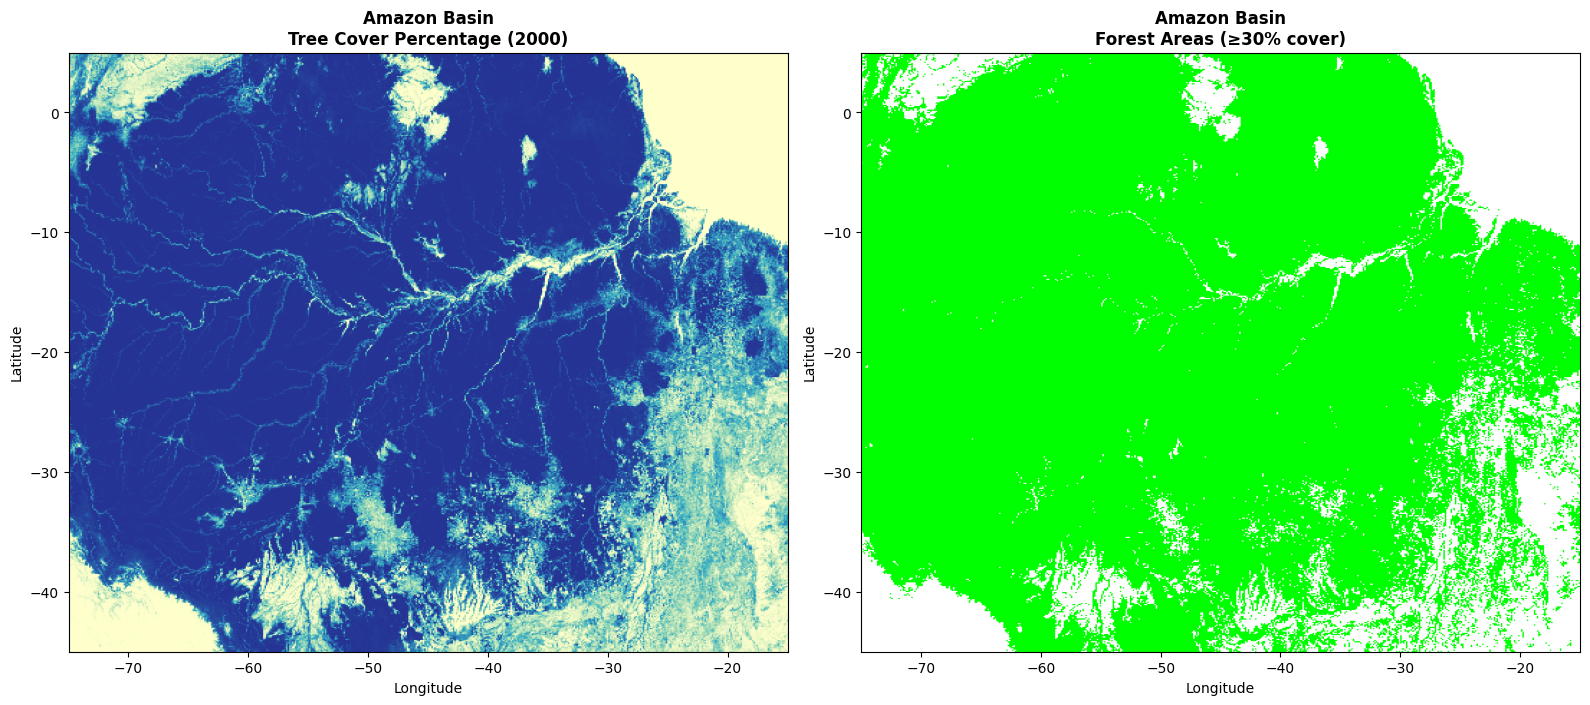

{'region_name': 'Amazon Basin',
 'total_area_km2': 7483358.34522886,
 'forest_area_km2': 5886133.302323791,
 'forest_percentage': 78.65630684486189,
 'mean_tree_cover': 73.72097715307882,
 'stats': {'treecover2000_max': 100,
  'treecover2000_mean': 73.72097715307882,
  'treecover2000_min': 0,
  'treecover2000_stdDev': 38.38563538688825}}

In [18]:
   analyze_forest_cover('Amazon Basin')


Loading forest datasets...
JAXA PALSAR dataset loaded
ESA WorldCover dataset loaded
Forest datasets ready!

🔥 DEFORESTATION ANALYSIS: Amazon Basin
Period: 2010-2023
Region: Amazon Basin

🔥 DEFORESTATION RESULTS:
  Original forest area (2000): 5,886,133 km²
  Forest loss area: 637,340 km²
  Forest loss percentage: 10.83%
  Annual loss rate: 0.773%/year


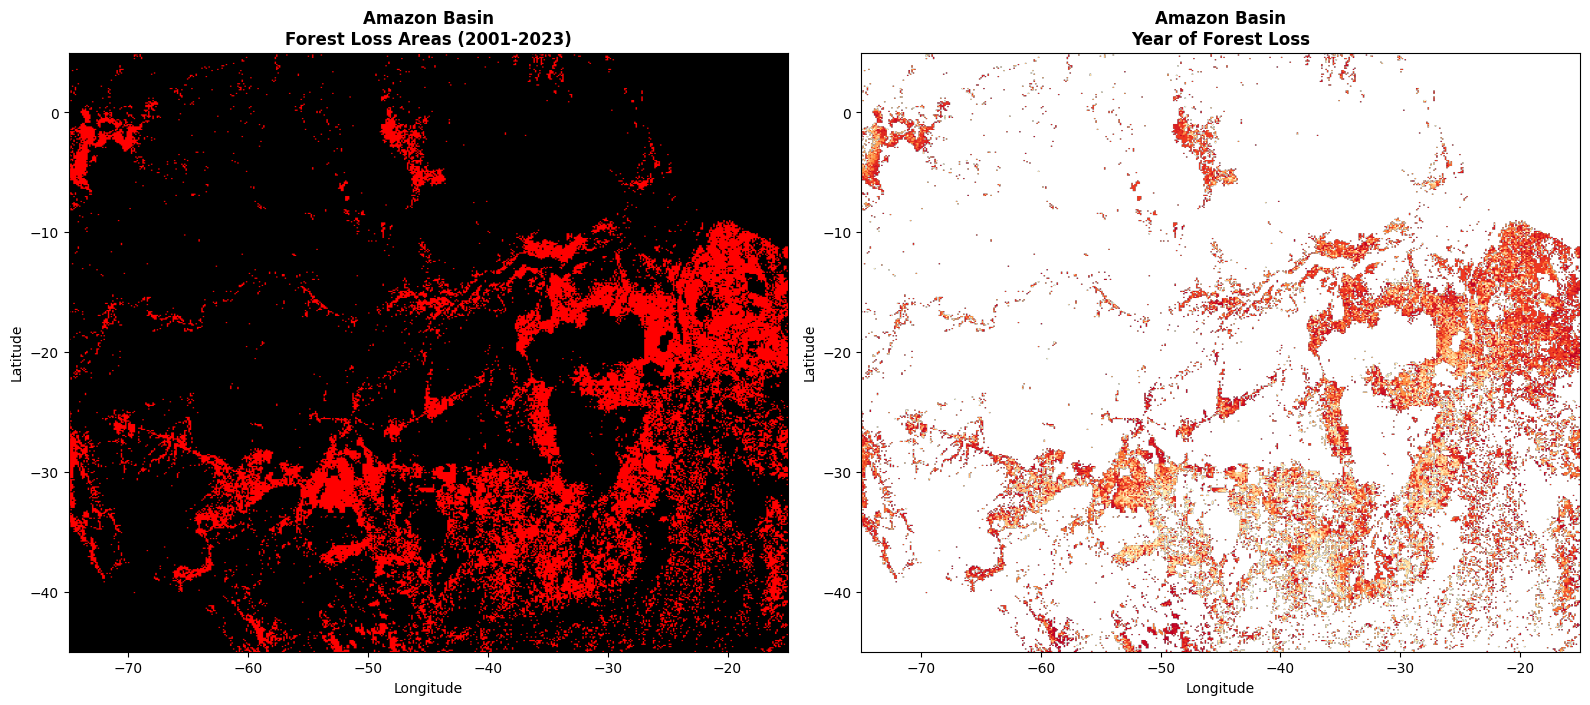

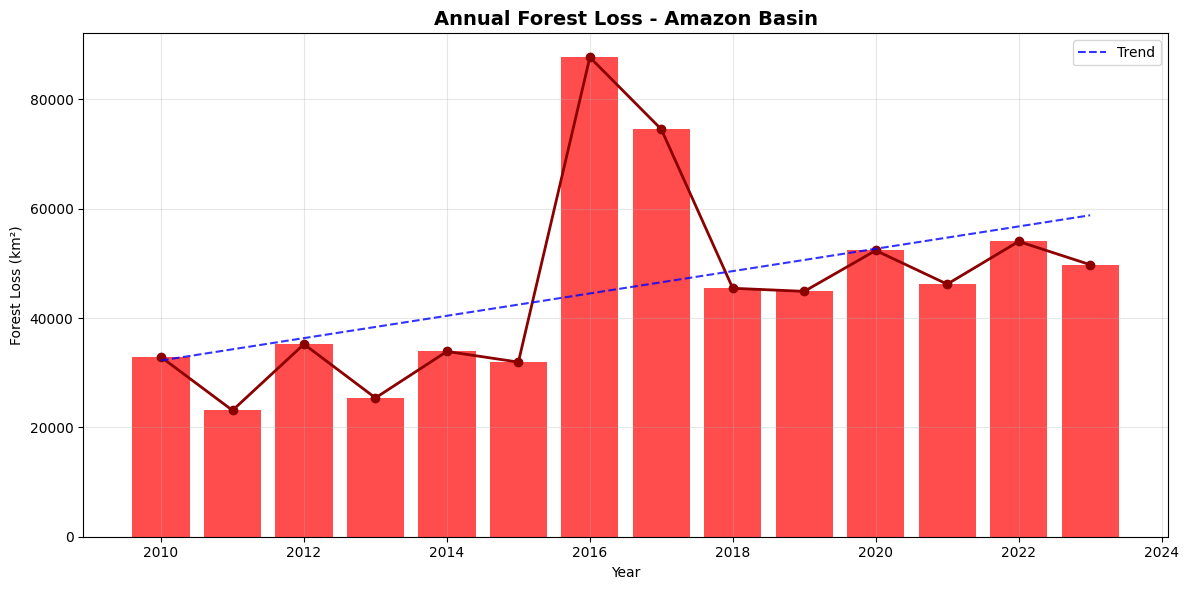


📈 YEARLY LOSS SUMMARY:
  Total loss (2010-2023): 637340 km²
  Peak loss year: 2016 (87700 km²)
  Average annual loss: 45524 km²/year


{'region_name': 'Amazon Basin',
 'period': '2010-2023',
 'original_forest_km2': 5886133.302323791,
 'loss_km2': 637340.2483461644,
 'loss_percentage': 10.827825596381725,
 'annual_rate': 0.7734161140272661,
 'yearly_loss': [{'year': 2010, 'loss_km2': 32863.47907020245},
  {'year': 2011, 'loss_km2': 23113.053640596077},
  {'year': 2012, 'loss_km2': 35225.14365869804},
  {'year': 2013, 'loss_km2': 25392.895487872796},
  {'year': 2014, 'loss_km2': 33893.36765650196},
  {'year': 2015, 'loss_km2': 31943.35043234877},
  {'year': 2016, 'loss_km2': 87700.17300443872},
  {'year': 2017, 'loss_km2': 74529.96262301078},
  {'year': 2018, 'loss_km2': 45449.66019112647},
  {'year': 2019, 'loss_km2': 44884.98862573382},
  {'year': 2020, 'loss_km2': 52364.04749575784},
  {'year': 2021, 'loss_km2': 46201.91366491348},
  {'year': 2022, 'loss_km2': 54011.67708234265},
  {'year': 2023, 'loss_km2': 49766.53571262034}]}

In [19]:
   analyze_deforestation('Amazon Basin', 2010, 2023)


Loading forest datasets...
JAXA PALSAR dataset loaded
ESA WorldCover dataset loaded
Forest datasets ready!

🌍 REGIONAL COMPARISON - COVER

Analyzing Amazon Basin...

🌲 FOREST COVER ANALYSIS: Amazon Basin
Region: Amazon Basin
Bounding box: [-75, -15, -45, 5]
Analysis year: 2000
Forest threshold: ≥30% tree cover

📊 RESULTS:
  Total area: 7,483,358 km²
  Forest area: 5,886,133 km²
  Forest coverage: 78.7%

📈 TREE COVER STATISTICS:
  Mean tree cover: 73.7%
  Range: 0.0% - 100.0%
  Standard deviation: 38.4%


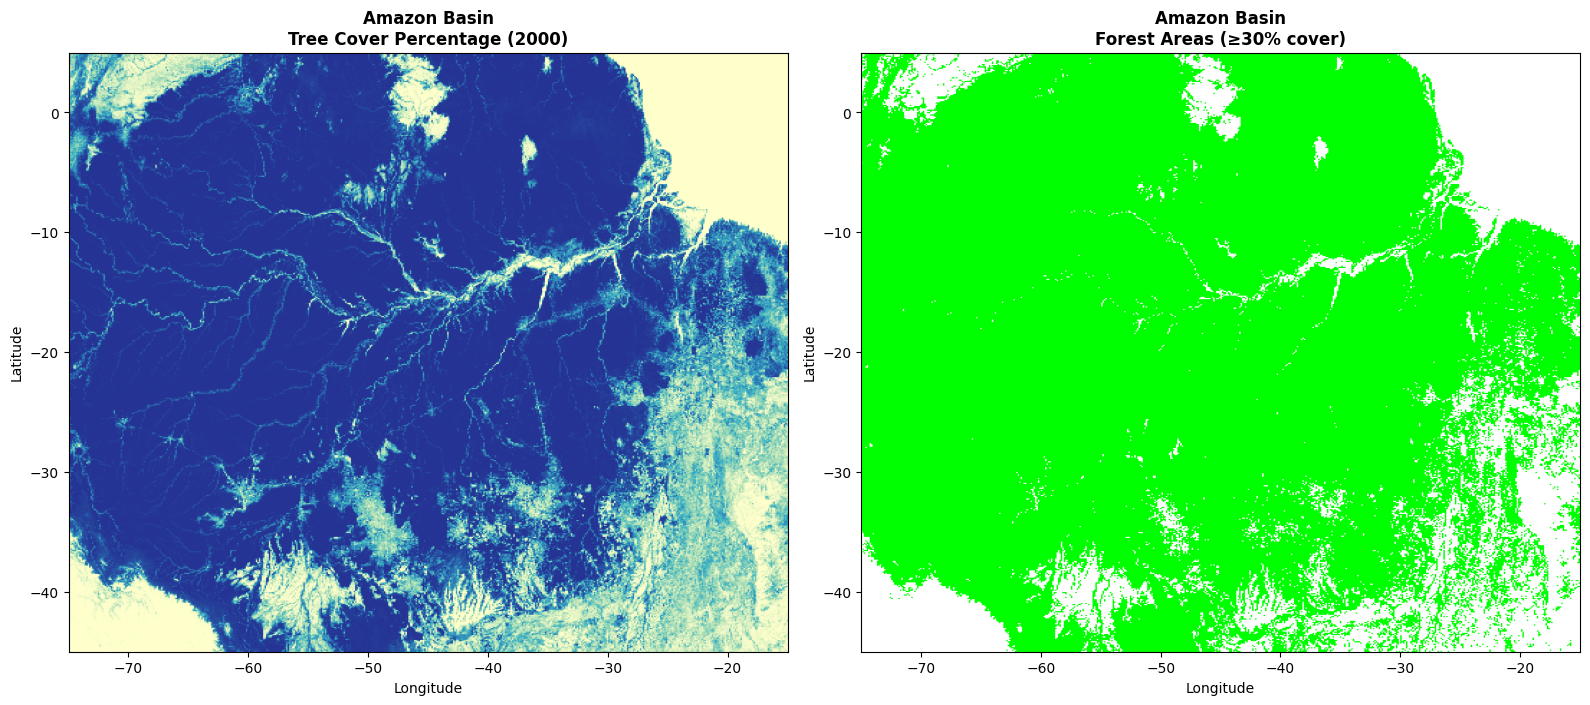


Analyzing Congo Basin...

🌲 FOREST COVER ANALYSIS: Congo Basin
Region: Congo Basin
Bounding box: [10, -5, 30, 5]
Analysis year: 2000
Forest threshold: ≥30% tree cover

📊 RESULTS:
  Total area: 2,483,459 km²
  Forest area: 2,288,177 km²
  Forest coverage: 92.1%

📈 TREE COVER STATISTICS:
  Mean tree cover: 79.8%
  Range: 0.0% - 100.0%
  Standard deviation: 26.7%


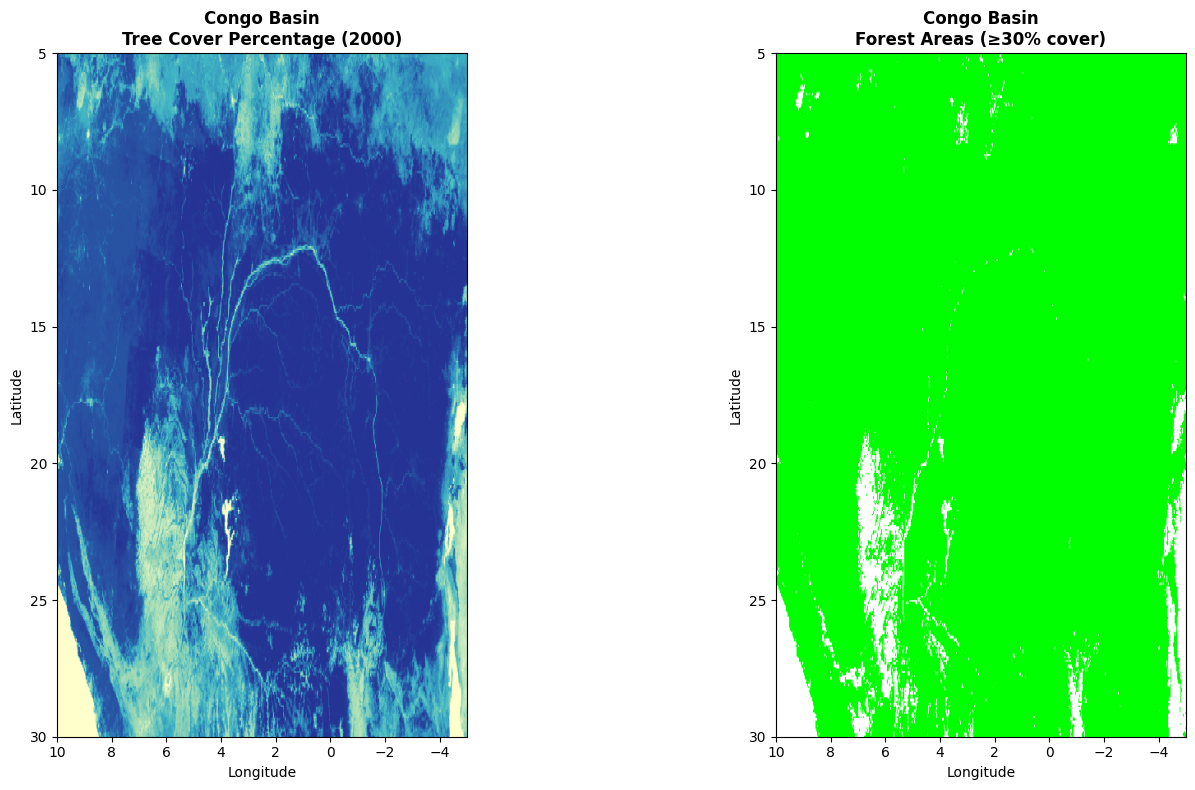


Analyzing Indonesian Borneo...

🌲 FOREST COVER ANALYSIS: Indonesian Borneo
Region: Indonesian Borneo
Bounding box: [108, -4, 119, 4]
Analysis year: 2000
Forest threshold: ≥30% tree cover

📊 RESULTS:
  Total area: 1,085,454 km²
  Forest area: 621,087 km²
  Forest coverage: 57.2%

📈 TREE COVER STATISTICS:
  Mean tree cover: 50.1%
  Range: 0.0% - 100.0%
  Standard deviation: 44.1%


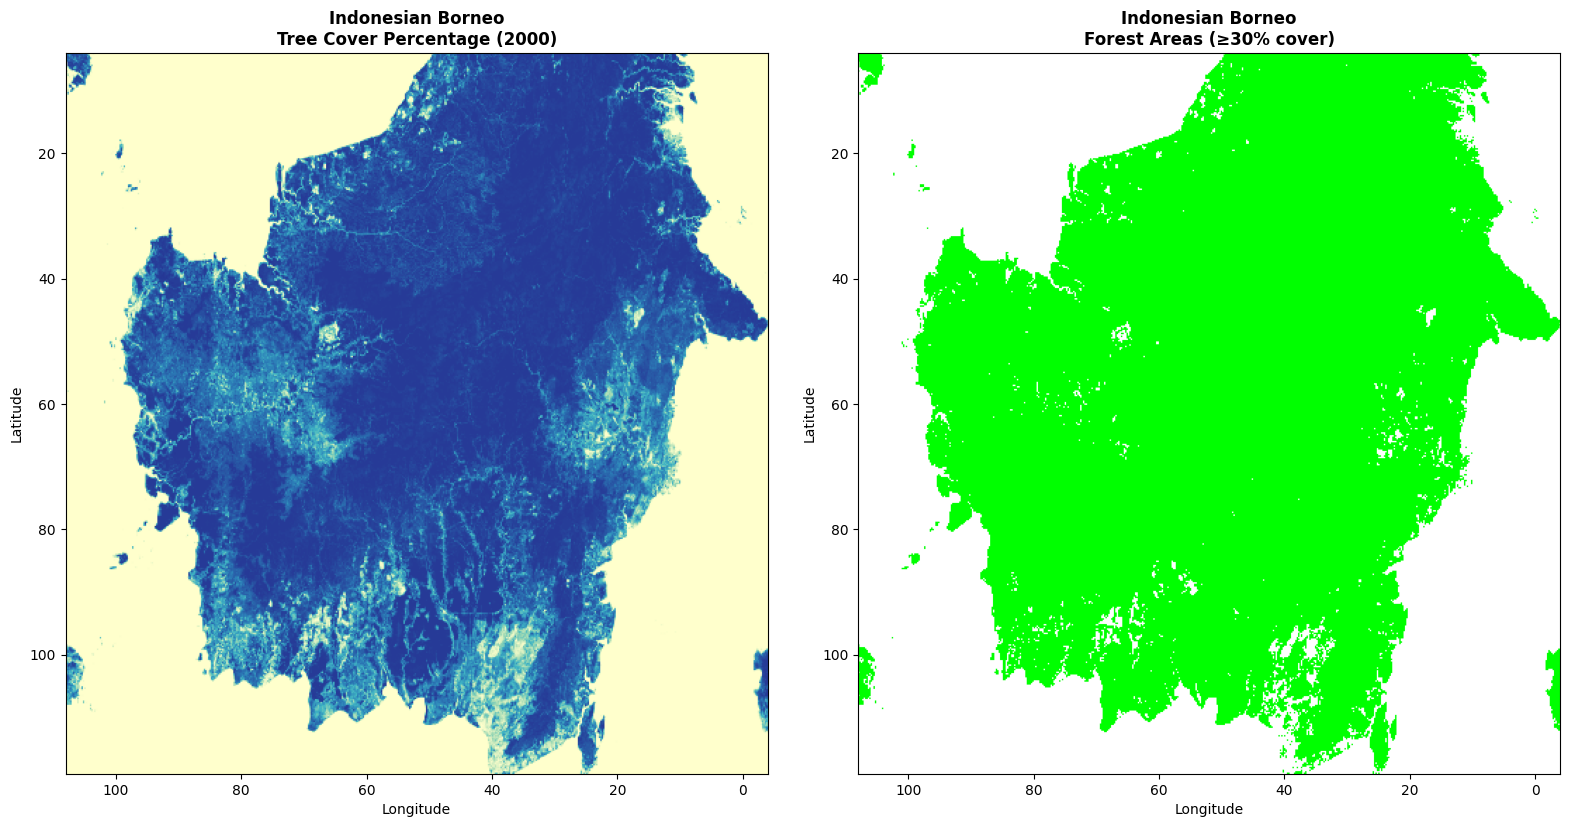

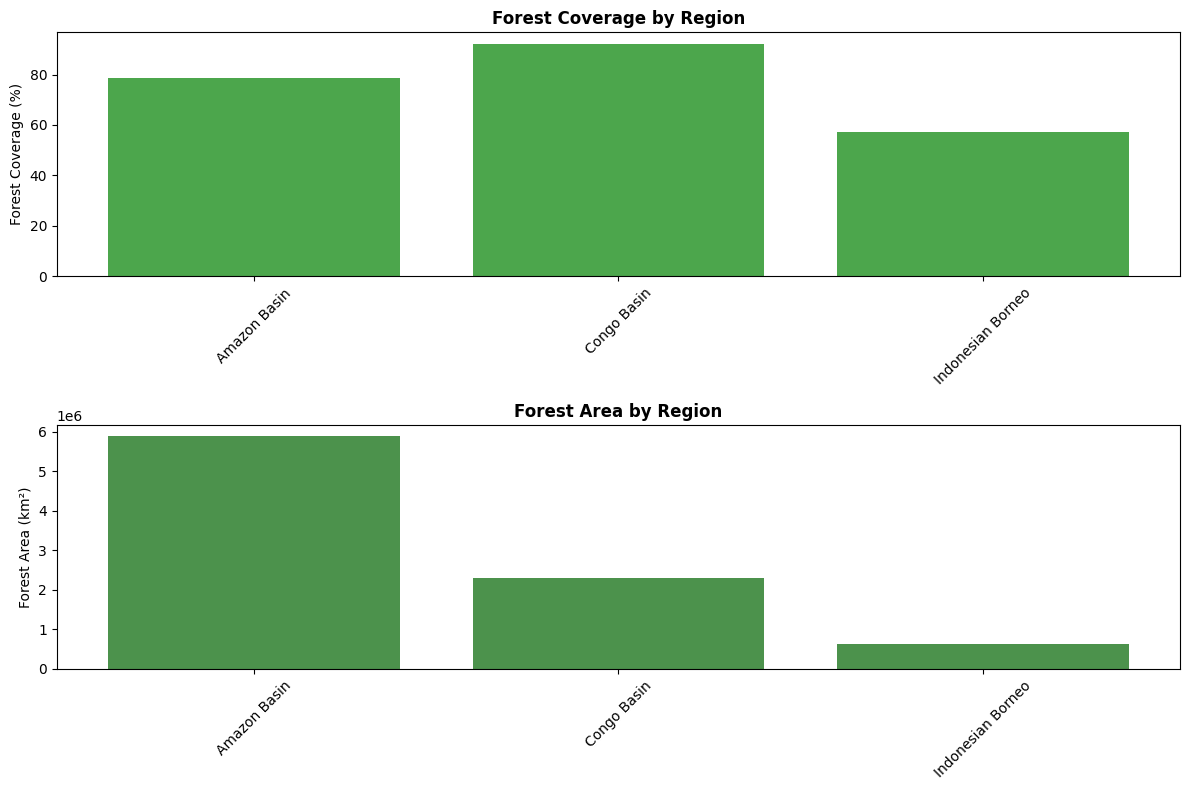

[{'region_name': 'Amazon Basin',
  'total_area_km2': 7483358.34522886,
  'forest_area_km2': 5886133.302323791,
  'forest_percentage': 78.65630684486189,
  'mean_tree_cover': 73.72097715307882,
  'stats': {'treecover2000_max': 100,
   'treecover2000_mean': 73.72097715307882,
   'treecover2000_min': 0,
   'treecover2000_stdDev': 38.38563538688825}},
 {'region_name': 'Congo Basin',
  'total_area_km2': 2483459.058064149,
  'forest_area_km2': 2288176.583448167,
  'forest_percentage': 92.13667428976242,
  'mean_tree_cover': 79.81189196240871,
  'stats': {'treecover2000_max': 100,
   'treecover2000_mean': 79.81189196240871,
   'treecover2000_min': 0,
   'treecover2000_stdDev': 26.67025032159176}},
 {'region_name': 'Indonesian Borneo',
  'total_area_km2': 1085454.3048885495,
  'forest_area_km2': 621086.9009771857,
  'forest_percentage': 57.219073910343624,
  'mean_tree_cover': 50.09755867151245,
  'stats': {'treecover2000_max': 100,
   'treecover2000_mean': 50.09755867151245,
   'treecover2000

In [20]:
   compare_forest_regions('cover')  # or 'loss'


In [21]:
"""
India Urban Forest and Green Cover Analysis Tool
Using Google Earth Engine for urban forest monitoring in Indian cities

This script focuses on:
1. Urban forest cover analysis in major Indian cities
2. Green space distribution in metropolitan areas
3. Forest loss due to urbanization
4. Comparison between cities
5. Delhi NCR detailed analysis
"""

import ee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import requests
from PIL import Image
import io

# Initialize Earth Engine
try:
    ee.Initialize(project='alpha-earth-473414')
    print("Earth Engine initialized successfully!")
except Exception as e:
    print(f"Error initializing Earth Engine: {e}")
    print("Please authenticate first using: ee.Authenticate()")

class IndiaUrbanForestAnalyzer:
    """
    Analyze urban forest cover and green spaces in Indian cities
    """

    def __init__(self):
        """Initialize the urban forest analyzer with datasets"""

        print("Loading forest and urban datasets for India...")

        # Hansen Global Forest Change (global dataset)
        self.hansen = ee.Image('UMD/hansen/global_forest_change_2023_v1_11')

        # ESA WorldCover for recent land cover including urban areas
        try:
            self.esa_worldcover = ee.ImageCollection('ESA/WorldCover/v200').first()
            print("ESA WorldCover dataset loaded (includes urban classification)")
        except:
            self.esa_worldcover = None
            print("ESA WorldCover dataset not accessible")

        # MODIS Land Cover for urban areas
        try:
            self.modis_landcover = ee.ImageCollection('MODIS/061/MCD12Q1').filterDate('2020-01-01', '2021-01-01').first()
            print("MODIS Land Cover dataset loaded")
        except:
            self.modis_landcover = None
            print("MODIS Land Cover dataset not accessible")

        # Landsat for high-resolution analysis
        try:
            self.landsat = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2020-01-01', '2023-01-01')
            print("Landsat 8 dataset loaded for high-resolution analysis")
        except:
            self.landsat = None
            print("Landsat dataset not accessible")

        print("Datasets ready for India analysis!")

    def get_india_cities(self):
        """
        Return bounding boxes and information for major Indian cities
        """

        cities = {
            'Delhi NCR': {
                'bbox': [76.8, 28.4, 77.5, 28.9],
                'center': [77.2, 28.6],
                'population': '32 million',
                'description': 'National Capital Region including Delhi, Gurgaon, Noida'
            },
            'Mumbai': {
                'bbox': [72.7, 18.9, 73.1, 19.3],
                'center': [72.9, 19.1],
                'population': '21 million',
                'description': 'Financial capital, Maharashtra'
            },
            'Bangalore': {
                'bbox': [77.4, 12.8, 77.8, 13.1],
                'center': [77.6, 13.0],
                'population': '13 million',
                'description': 'Silicon Valley of India, Karnataka'
            },
            'Hyderabad': {
                'bbox': [78.2, 17.2, 78.7, 17.6],
                'center': [78.4, 17.4],
                'population': '10 million',
                'description': 'IT hub, Telangana'
            },
            'Chennai': {
                'bbox': [80.1, 12.8, 80.3, 13.2],
                'center': [80.2, 13.0],
                'population': '11 million',
                'description': 'Detroit of India, Tamil Nadu'
            },
            'Kolkata': {
                'bbox': [88.2, 22.4, 88.5, 22.7],
                'center': [88.4, 22.6],
                'population': '15 million',
                'description': 'Cultural capital, West Bengal'
            },
            'Pune': {
                'bbox': [73.7, 18.4, 73.9, 18.6],
                'center': [73.8, 18.5],
                'population': '7 million',
                'description': 'Oxford of the East, Maharashtra'
            },
            'Ahmedabad': {
                'bbox': [72.4, 22.9, 72.7, 23.2],
                'center': [72.6, 23.0],
                'population': '8 million',
                'description': 'Commercial hub, Gujarat'
            }
        }

        return cities

    def analyze_delhi_detailed(self, year_range='2020-2023'):
        """
        Detailed analysis of Delhi NCR region
        """

        print("🏙️ DETAILED DELHI NCR ANALYSIS")
        print("=" * 60)

        # Delhi NCR extended boundary
        delhi_bbox = [76.5, 28.2, 77.8, 29.0]  # Extended to include full NCR
        delhi_region = ee.Geometry.Rectangle(delhi_bbox)

        print("Region: Delhi National Capital Region (Extended)")
        print(f"Analysis period: {year_range}")
        print("Includes: Delhi, Gurgaon, Noida, Faridabad, Ghaziabad")

        # Analyze different aspects
        print("\n1. FOREST COVER ANALYSIS")
        print("-" * 30)
        forest_result = self.analyze_urban_forest_cover('Delhi NCR', delhi_bbox)

        print("\n2. URBANIZATION IMPACT")
        print("-" * 30)
        urban_result = self.analyze_urbanization_impact('Delhi NCR', delhi_bbox)

        print("\n3. GREEN SPACE DISTRIBUTION")
        print("-" * 30)
        green_result = self.analyze_green_spaces('Delhi NCR', delhi_bbox)

        print("\n4. FOREST LOSS ANALYSIS")
        print("-" * 30)
        loss_result = self.analyze_urban_deforestation('Delhi NCR', delhi_bbox, 2010, 2023)

        # Create comprehensive visualization
        self.create_delhi_dashboard(delhi_region, delhi_bbox)

        return {
            'forest_cover': forest_result,
            'urbanization': urban_result,
            'green_spaces': green_result,
            'forest_loss': loss_result
        }

    def analyze_urban_forest_cover(self, city_name, bbox, min_tree_cover=10):
        """
        Analyze forest cover in urban areas (lower threshold for urban forests)

        Args:
            city_name: Name of the city
            bbox: Bounding box coordinates
            min_tree_cover: Minimum tree cover % (lower for urban areas)
        """

        print(f"\n🌳 URBAN FOREST COVER: {city_name}")
        print("-" * 40)

        region = ee.Geometry.Rectangle(bbox)

        try:
            # Get tree cover (2000 baseline)
            tree_cover = self.hansen.select('treecover2000')

            # Urban forest threshold (lower than natural forests)
            urban_forest_mask = tree_cover.gte(min_tree_cover)

            # Parks and dense green areas
            dense_forest_mask = tree_cover.gte(30)

            # Calculate statistics
            stats = tree_cover.reduceRegion(
                reducer=ee.Reducer.mean().combine(
                    reducer2=ee.Reducer.minMax(), sharedInputs=True
                ).combine(
                    reducer2=ee.Reducer.stdDev(), sharedInputs=True
                ),
                geometry=region,
                scale=100,  # Higher resolution for urban areas
                maxPixels=1e9
            ).getInfo()

            # Calculate areas
            total_area = ee.Image.pixelArea().reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=100,
                maxPixels=1e9
            ).getInfo()

            urban_forest_area = urban_forest_mask.multiply(ee.Image.pixelArea()).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=100,
                maxPixels=1e9
            ).getInfo()

            dense_forest_area = dense_forest_mask.multiply(ee.Image.pixelArea()).reduceRegion(
                reducer=ee.Reducer.sum(),
                geometry=region,
                scale=100,
                maxPixels=1e9
            ).getInfo()

            # Extract values
            total_area_km2 = total_area.get('area', 1) / 1e6
            urban_forest_km2 = urban_forest_area.get('treecover2000', 0) / 1e6
            dense_forest_km2 = dense_forest_area.get('treecover2000', 0) / 1e6

            urban_forest_pct = (urban_forest_km2 / total_area_km2) * 100
            dense_forest_pct = (dense_forest_km2 / total_area_km2) * 100

            mean_cover = stats.get('treecover2000_mean', 0)

            print(f"🏙️ {city_name} - Urban Forest Analysis:")
            print(f"  Total area: {total_area_km2:.1f} km²")
            print(f"  Urban green cover (≥{min_tree_cover}%): {urban_forest_km2:.1f} km² ({urban_forest_pct:.1f}%)")
            print(f"  Dense forest/parks (≥30%): {dense_forest_km2:.1f} km² ({dense_forest_pct:.1f}%)")
            print(f"  Average tree cover: {mean_cover:.1f}%")

            # WHO recommendation: 9 m²/person of green space minimum
            cities_info = self.get_india_cities()
            if city_name in cities_info:
                population_str = cities_info[city_name]['population']
                pop_millions = float(population_str.split()[0])
                green_per_person = (urban_forest_km2 * 1e6) / (pop_millions * 1e6)  # m² per person

                print(f"  Population: ~{pop_millions} million")
                print(f"  Green space per person: {green_per_person:.1f} m²")
                print(f"  WHO recommendation: 9 m²/person {'✅' if green_per_person >= 9 else '❌'}")

            return {
                'city_name': city_name,
                'total_area_km2': total_area_km2,
                'urban_forest_km2': urban_forest_km2,
                'urban_forest_pct': urban_forest_pct,
                'dense_forest_km2': dense_forest_km2,
                'dense_forest_pct': dense_forest_pct,
                'mean_tree_cover': mean_cover,
                'green_per_person': green_per_person if city_name in cities_info else None
            }

        except Exception as e:
            print(f"Error analyzing urban forest cover: {e}")
            return None

    def analyze_urbanization_impact(self, city_name, bbox):
        """
        Analyze the impact of urbanization on forest cover
        """

        print(f"\n🏗️ URBANIZATION IMPACT: {city_name}")
        print("-" * 40)

        region = ee.Geometry.Rectangle(bbox)

        try:
            # Use ESA WorldCover to identify urban areas
            if self.esa_worldcover:
                # ESA WorldCover classes: 50 = Built-up
                urban_areas = self.esa_worldcover.select('Map').eq(50)

                # Calculate urban area
                urban_area = urban_areas.multiply(ee.Image.pixelArea()).reduceRegion(
                    reducer=ee.Reducer.sum(),
                    geometry=region,
                    scale=100,
                    maxPixels=1e9
                ).getInfo()

                urban_area_km2 = urban_area.get('Map', 0) / 1e6

                # Calculate forest cover in urban vs non-urban areas
                tree_cover = self.hansen.select('treecover2000')

                # Forest in urban areas
                urban_forest = tree_cover.updateMask(urban_areas).reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=region,
                    scale=100,
                    maxPixels=1e9
                ).getInfo()

                # Forest in non-urban areas
                non_urban_forest = tree_cover.updateMask(urban_areas.Not()).reduceRegion(
                    reducer=ee.Reducer.mean(),
                    geometry=region,
                    scale=100,
                    maxPixels=1e9
                ).getInfo()

                urban_tree_cover = urban_forest.get('treecover2000', 0)
                non_urban_tree_cover = non_urban_forest.get('treecover2000', 0)

                total_area_km2 = region.area().divide(1e6).getInfo()
                urban_pct = (urban_area_km2 / total_area_km2) * 100

                print(f"🏙️ Urban Development Analysis:")
                print(f"  Total area: {total_area_km2:.1f} km²")
                print(f"  Urban built-up area: {urban_area_km2:.1f} km² ({urban_pct:.1f}%)")
                print(f"  Tree cover in urban areas: {urban_tree_cover:.1f}%")
                print(f"  Tree cover in non-urban areas: {non_urban_tree_cover:.1f}%")
                print(f"  Urban forest deficit: {non_urban_tree_cover - urban_tree_cover:.1f}%")

                return {
                    'city_name': city_name,
                    'urban_area_km2': urban_area_km2,
                    'urban_percentage': urban_pct,
                    'urban_tree_cover': urban_tree_cover,
                    'non_urban_tree_cover': non_urban_tree_cover,
                    'forest_deficit': non_urban_tree_cover - urban_tree_cover
                }

        except Exception as e:
            print(f"Error analyzing urbanization impact: {e}")
            return None

    def analyze_green_spaces(self, city_name, bbox):
        """
        Analyze distribution of green spaces (parks, gardens, etc.)
        """

        print(f"\n🌳 GREEN SPACES ANALYSIS: {city_name}")
        print("-" * 40)

        region = ee.Geometry.Rectangle(bbox)

        try:
            # Use Landsat NDVI to identify green spaces
            if self.landsat:
                # Get recent Landsat imagery
                landsat_recent = self.landsat.filterBounds(region).filterDate('2022-01-01', '2023-01-01')

                if landsat_recent.size().getInfo() > 0:
                    landsat_composite = landsat_recent.median()

                    # Calculate NDVI (Normalized Difference Vegetation Index)
                    nir = landsat_composite.select('SR_B5')  # Near Infrared
                    red = landsat_composite.select('SR_B4')  # Red
                    ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

                    # Different vegetation categories based on NDVI
                    dense_vegetation = ndvi.gt(0.6)     # Parks, dense trees
                    moderate_vegetation = ndvi.gt(0.3).And(ndvi.lte(0.6))  # Gardens, lawns
                    sparse_vegetation = ndvi.gt(0.1).And(ndvi.lte(0.3))    # Sparse green

                    # Calculate areas
                    dense_area = dense_vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
                        reducer=ee.Reducer.sum(), geometry=region, scale=100, maxPixels=1e9
                    ).getInfo()

                    moderate_area = moderate_vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
                        reducer=ee.Reducer.sum(), geometry=region, scale=100, maxPixels=1e9
                    ).getInfo()

                    sparse_area = sparse_vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
                        reducer=ee.Reducer.sum(), geometry=region, scale=100, maxPixels=1e9
                    ).getInfo()

                    dense_km2 = dense_area.get('NDVI', 0) / 1e6
                    moderate_km2 = moderate_area.get('NDVI', 0) / 1e6
                    sparse_km2 = sparse_area.get('NDVI', 0) / 1e6

                    total_green = dense_km2 + moderate_km2 + sparse_km2
                    total_area = region.area().divide(1e6).getInfo()

                    print(f"🌱 Green Space Categories (NDVI-based):")
                    print(f"  Dense vegetation (parks): {dense_km2:.1f} km²")
                    print(f"  Moderate vegetation (gardens): {moderate_km2:.1f} km²")
                    print(f"  Sparse vegetation: {sparse_km2:.1f} km²")
                    print(f"  Total green spaces: {total_green:.1f} km² ({(total_green/total_area)*100:.1f}%)")

                    # Average NDVI for the city
                    avg_ndvi = ndvi.reduceRegion(
                        reducer=ee.Reducer.mean(), geometry=region, scale=100, maxPixels=1e9
                    ).getInfo()

                    avg_ndvi_val = avg_ndvi.get('NDVI', 0)
                    print(f"  Average NDVI: {avg_ndvi_val:.3f} (0=no vegetation, 1=dense vegetation)")

                    return {
                        'city_name': city_name,
                        'dense_vegetation_km2': dense_km2,
                        'moderate_vegetation_km2': moderate_km2,
                        'sparse_vegetation_km2': sparse_km2,
                        'total_green_km2': total_green,
                        'green_percentage': (total_green/total_area)*100,
                        'avg_ndvi': avg_ndvi_val
                    }

        except Exception as e:
            print(f"Error analyzing green spaces: {e}")
            return None

    def analyze_urban_deforestation(self, city_name, bbox, start_year=2010, end_year=2023):
        """
        Analyze forest loss in urban areas
        """

        print(f"\n🔥 URBAN FOREST LOSS: {city_name}")
        print("-" * 40)

        region = ee.Geometry.Rectangle(bbox)

        try:
            # Hansen forest loss data
            loss = self.hansen.select('loss')
            loss_year = self.hansen.select('lossyear')
            tree_cover_2000 = self.hansen.select('treecover2000')

            # Filter by year range
            year_mask = loss_year.gte(start_year - 2000).And(loss_year.lte(end_year - 2000))
            filtered_loss = loss.updateMask(year_mask)

            # Calculate loss area
            loss_area = filtered_loss.multiply(ee.Image.pixelArea()).reduceRegion(
                reducer=ee.Reducer.sum(), geometry=region, scale=100, maxPixels=1e9
            ).getInfo()

            # Original forest area in 2000 (using lower urban threshold)
            original_forest = tree_cover_2000.gte(10)  # Urban forest threshold
            original_area = original_forest.multiply(ee.Image.pixelArea()).reduceRegion(
                reducer=ee.Reducer.sum(), geometry=region, scale=100, maxPixels=1e9
            ).getInfo()

            loss_km2 = loss_area.get('loss', 0) / 1e6
            original_km2 = original_area.get('treecover2000', 1) / 1e6
            loss_pct = (loss_km2 / original_km2) * 100 if original_km2 > 0 else 0

            print(f"📊 Forest Loss Analysis ({start_year}-{end_year}):")
            print(f"  Original forest area (2000): {original_km2:.1f} km²")
            print(f"  Forest loss: {loss_km2:.1f} km² ({loss_pct:.1f}% of original)")
            print(f"  Annual loss rate: {loss_pct/(end_year-start_year+1):.2f}%/year")

            # Compare with typical urban growth rate
            if loss_pct > 15:
                status = "🚨 High deforestation"
            elif loss_pct > 5:
                status = "⚠️ Moderate deforestation"
            else:
                status = "✅ Low deforestation"

            print(f"  Status: {status}")

            return {
                'city_name': city_name,
                'period': f"{start_year}-{end_year}",
                'original_forest_km2': original_km2,
                'loss_km2': loss_km2,
                'loss_percentage': loss_pct,
                'annual_rate': loss_pct/(end_year-start_year+1),
                'status': status
            }

        except Exception as e:
            print(f"Error analyzing urban deforestation: {e}")
            return None

    def create_delhi_dashboard(self, region, bbox):
        """
        Create a comprehensive visualization dashboard for Delhi
        """

        try:
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle('Delhi NCR - Urban Forest Analysis Dashboard', fontsize=16, fontweight='bold')

            # 1. Tree cover percentage
            tree_cover = self.hansen.select('treecover2000')
            self.plot_ee_image(tree_cover, region, bbox, axes[0,0],
                             'Tree Cover 2000 (%)',
                             {'min': 0, 'max': 80, 'palette': ['#ffcccc', '#66cc66', '#006600']})

            # 2. Forest loss
            loss = self.hansen.select('loss')
            self.plot_ee_image(loss, region, bbox, axes[0,1],
                             'Forest Loss (2001-2023)',
                             {'min': 0, 'max': 1, 'palette': ['#000000', '#ff0000']})

            # 3. Loss year
            loss_year = self.hansen.select('lossyear').updateMask(loss)
            self.plot_ee_image(loss_year, region, bbox, axes[0,2],
                             'Year of Forest Loss',
                             {'min': 1, 'max': 23, 'palette': ['#ffffcc', '#ff0000']})

            if self.esa_worldcover:
                # 4. Urban areas
                urban = self.esa_worldcover.select('Map').eq(50)
                self.plot_ee_image(urban, region, bbox, axes[1,0],
                                 'Urban Built-up Areas',
                                 {'min': 0, 'max': 1, 'palette': ['#000000', '#cccccc']})

            # 5. Urban forest (low threshold)
            urban_forest = tree_cover.gte(10)
            self.plot_ee_image(urban_forest, region, bbox, axes[1,1],
                             'Urban Green Spaces (≥10%)',
                             {'min': 0, 'max': 1, 'palette': ['#000000', '#00ff00']})

            # 6. Parks and dense forest
            dense_forest = tree_cover.gte(30)
            self.plot_ee_image(dense_forest, region, bbox, axes[1,2],
                             'Parks & Dense Forest (≥30%)',
                             {'min': 0, 'max': 1, 'palette': ['#000000', '#006600']})

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Could not create Delhi dashboard: {e}")

    def plot_ee_image(self, image, region, bbox, ax, title, vis_params):
        """Helper function to plot Earth Engine images"""

        try:
            url = image.getThumbURL({
                'region': region,
                'dimensions': '400x400',
                'format': 'png',
                'crs': 'EPSG:4326',
                **vis_params
            })

            response = requests.get(url)
            response.raise_for_status()

            img = Image.open(io.BytesIO(response.content))
            img_array = np.array(img)

            ax.imshow(img_array, extent=bbox)
            ax.set_title(title, fontsize=10)
            ax.set_xlabel('Longitude')
            ax.set_ylabel('Latitude')

        except Exception as e:
            ax.text(0.5, 0.5, f'Error loading\n{title}',
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_title(title, fontsize=10)

    def compare_indian_cities(self, analysis_type='forest_cover'):
        """
        Compare forest metrics across major Indian cities
        """

        cities = self.get_india_cities()
        results = []

        print(f"\n🏙️ INDIAN CITIES COMPARISON - {analysis_type.upper()}")
        print("=" * 70)

        for city_name, city_info in cities.items():
            print(f"\nAnalyzing {city_name}...")

            if analysis_type == 'forest_cover':
                result = self.analyze_urban_forest_cover(city_name, city_info['bbox'])
            elif analysis_type == 'deforestation':
                result = self.analyze_urban_deforestation(city_name, city_info['bbox'])
            else:
                result = self.analyze_green_spaces(city_name, city_info['bbox'])

            if result:
                result.update(city_info)  # Add city info
                results.append(result)

        # Create comparison visualization
        if results:
            self.plot_cities_comparison(results, analysis_type)

        return results

    def plot_cities_comparison(self, results, analysis_type):
        """Plot comparison charts for Indian cities"""

        df = pd.DataFrame(results)

        plt.figure(figsize=(15, 10))

        if analysis_type == 'forest_cover':
            plt.subplot(2, 2, 1)
            plt.barh(df['city_name'], df['urban_forest_pct'], color='green', alpha=0.7)
            plt.title('Urban Forest Coverage (%)', fontweight='bold')
            plt.xlabel('Forest Coverage (%)')

            plt.subplot(2, 2, 2)
            plt.barh(df['city_name'], df['dense_forest_pct'], color='darkgreen', alpha=0.7)
            plt.title('Parks & Dense Forest (%)', fontweight='bold')
            plt.xlabel('Dense Forest Coverage (%)')

            plt.subplot(2, 2, 3)
            valid_green_per_person = df.dropna(subset=['green_per_person'])
            plt.barh(valid_green_per_person['city_name'], valid_green_per_person['green_per_person'],
                    color=['red' if x < 9 else 'green' for x in valid_green_per_person['green_per_person']],
                    alpha=0.7)
            plt.axvline(x=9, color='orange', linestyle='--', label='WHO Recommendation (9 m²)')
            plt.title('Green Space per Person (m²)', fontweight='bold')
            plt.xlabel('Green Space per Person (m²)')
            plt.legend()

            plt.subplot(2, 2, 4)
            plt.barh(df['city_name'], df['mean_tree_cover'], color='lightgreen', alpha=0.7)
            plt.title('Average Tree Cover (%)', fontweight='bold')
            plt.xlabel('Average Tree Cover (%)')

        elif analysis_type == 'deforestation':
            plt.subplot(1, 2, 1)
            plt.barh(df['city_name'], df['loss_percentage'], color='red', alpha=0.7)
            plt.title('Total Forest Loss (%)', fontweight='bold')
            plt.xlabel('Forest Loss (%)')

            plt.subplot(1, 2, 2)
            plt.barh(df['city_name'], df['annual_rate'], color='darkred', alpha=0.7)
            plt.title('Annual Deforestation Rate (%/year)', fontweight='bold')
            plt.xlabel('Annual Loss Rate (%/year)')

        plt.tight_layout()
        plt.show()


# Quick analysis functions
def analyze_delhi():
    """Comprehensive Delhi analysis"""
    analyzer = IndiaUrbanForestAnalyzer()
    return analyzer.analyze_delhi_detailed()

def analyze_city_forest_cover(city_name='Delhi NCR'):
    """Analyze forest cover for a specific Indian city"""
    analyzer = IndiaUrbanForestAnalyzer()
    cities = analyzer.get_india_cities()

    if city_name in cities:
        return analyzer.analyze_urban_forest_cover(city_name, cities[city_name]['bbox'])
    else:
        print(f"City '{city_name}' not found. Available cities:")
        for name in cities.keys():
            print(f"  - {name}")

def compare_indian_cities(analysis_type='forest_cover'):
    """Compare all major Indian cities"""
    analyzer = IndiaUrbanForestAnalyzer()
    return analyzer.compare_indian_cities(analysis_type)

def show_indian_cities():
    """Display information about available Indian cities"""
    analyzer = IndiaUrbanForestAnalyzer()
    cities = analyzer.get_india_cities()

    print("\n🏙️ AVAILABLE INDIAN CITIES FOR ANALYSIS")
    print("=" * 60)

    for city_name, info in cities.items():
        print(f"\n📍 {city_name}")
        print(f"   Population: {info['population']}")
        print(f"   Description: {info['description']}")
        print(f"   Coordinates: {info['center']}")
        print(f"   Bounding box: {info['bbox']}")

def analyze_urbanization_impact(city_name='Delhi NCR'):
    """Analyze impact of urbanization on forests"""
    analyzer = IndiaUrbanForestAnalyzer()
    cities = analyzer.get_india_cities()

    if city_name in cities:
        return analyzer.analyze_urbanization_impact(city_name, cities[city_name]['bbox'])
    else:
        print(f"City '{city_name}' not found.")
        show_indian_cities()

def analyze_green_spaces(city_name='Delhi NCR'):
    """Analyze green spaces distribution"""
    analyzer = IndiaUrbanForestAnalyzer()
    cities = analyzer.get_india_cities()

    if city_name in cities:
        return analyzer.analyze_green_spaces(city_name, cities[city_name]['bbox'])
    else:
        print(f"City '{city_name}' not found.")
        show_indian_cities()


# Main demo function
def demo_india_analysis():
    """
    Run a comprehensive demo of India urban forest analysis
    """

    print("🇮🇳 INDIA URBAN FOREST ANALYSIS - COMPREHENSIVE DEMO")
    print("=" * 70)

    # Show available cities
    show_indian_cities()

    print("\n" + "="*50)
    print("STARTING ANALYSIS...")
    print("="*50)

    # 1. Detailed Delhi analysis
    print("\n1️⃣ COMPREHENSIVE DELHI NCR ANALYSIS")
    delhi_results = analyze_delhi()

    # 2. Compare major cities
    print("\n2️⃣ COMPARING FOREST COVER ACROSS INDIAN CITIES")
    city_comparison = compare_indian_cities('forest_cover')

    # 3. Show deforestation comparison
    print("\n3️⃣ COMPARING DEFORESTATION ACROSS CITIES")
    deforestation_comparison = compare_indian_cities('deforestation')

    print("\n" + "="*50)
    print("ANALYSIS COMPLETE!")
    print("="*50)

    return {
        'delhi_analysis': delhi_results,
        'city_forest_comparison': city_comparison,
        'deforestation_comparison': deforestation_comparison
    }


# Usage examples and instructions
print("\n" + "="*80)
print("INDIA URBAN FOREST ANALYSIS TOOL")
print("="*80)
print("\n🌆 FOCUS AREAS:")
print("   • Delhi NCR (National Capital Region)")
print("   • Mumbai (Financial Capital)")
print("   • Bangalore (Silicon Valley)")
print("   • Hyderabad, Chennai, Kolkata, Pune, Ahmedabad")
print("\n🔍 ANALYSIS FEATURES:")
print("   ✅ Urban forest cover percentage")
print("   ✅ Green space per person (WHO standards)")
print("   ✅ Impact of urbanization on forests")
print("   ✅ NDVI-based green space analysis")
print("   ✅ Forest loss due to urban expansion")
print("   ✅ City-to-city comparisons")
print("   ✅ Visual dashboards and maps")

print("\n🚀 QUICK START COMMANDS:")
print("\n1. Show available cities:")
print("   show_indian_cities()")

print("\n2. Comprehensive Delhi analysis:")
print("   delhi_results = analyze_delhi()")

print("\n3. Analyze specific city forest cover:")
print("   analyze_city_forest_cover('Mumbai')")
print("   analyze_city_forest_cover('Bangalore')")

print("\n4. Compare all Indian cities:")
print("   compare_indian_cities('forest_cover')")
print("   compare_indian_cities('deforestation')")

print("\n5. Analyze urbanization impact:")
print("   analyze_urbanization_impact('Delhi NCR')")

print("\n6. Green spaces analysis:")
print("   analyze_green_spaces('Bangalore')")

print("\n7. Run complete demo:")
print("   results = demo_india_analysis()")

print("\n📊 WHAT YOU'LL GET:")
print("   • Forest cover percentage in urban areas")
print("   • Green space per person vs WHO recommendations (9 m²/person)")
print("   • Urban vs non-urban forest cover comparison")
print("   • NDVI-based vegetation analysis")
print("   • Historical forest loss (2000-2023)")
print("   • Interactive maps and visualizations")
print("   • City rankings and comparisons")

print("\n🎯 DELHI NCR SPECIAL FEATURES:")
print("   • Extended NCR boundary (includes Gurgaon, Noida, Faridabad)")
print("   • Detailed 6-panel dashboard")
print("   • Urban forest vs parks classification")
print("   • Population-based green space metrics")
print("   • Forest loss timeline analysis")

print("\n💡 RESEARCH INSIGHTS:")
print("   • Identify cities with best/worst green cover")
print("   • Track urbanization impact on forests")
print("   • Compare against international standards")
print("   • Spot deforestation hotspots")
print("   • Plan urban green space improvements")

print("\n🌿 THRESHOLDS USED:")
print("   • Urban Forest: ≥10% tree cover (lower than natural forests)")
print("   • Dense Forest/Parks: ≥30% tree cover")
print("   • NDVI Categories: >0.6 (dense), 0.3-0.6 (moderate), 0.1-0.3 (sparse)")
print("   • WHO Green Space Standard: 9 m²/person minimum")

print(f"\n🛰️ DATASETS:")
print("   • Hansen Global Forest Change (2000-2023) - 30m resolution")
print("   • ESA WorldCover - Urban area classification")
print("   • Landsat 8 - NDVI vegetation analysis")
print("   • MODIS Land Cover - Urban context")

print("\n" + "="*80)

Earth Engine initialized successfully!

INDIA URBAN FOREST ANALYSIS TOOL

🌆 FOCUS AREAS:
   • Delhi NCR (National Capital Region)
   • Mumbai (Financial Capital)
   • Bangalore (Silicon Valley)
   • Hyderabad, Chennai, Kolkata, Pune, Ahmedabad

🔍 ANALYSIS FEATURES:
   ✅ Urban forest cover percentage
   ✅ Green space per person (WHO standards)
   ✅ Impact of urbanization on forests
   ✅ NDVI-based green space analysis
   ✅ Forest loss due to urban expansion
   ✅ City-to-city comparisons
   ✅ Visual dashboards and maps

🚀 QUICK START COMMANDS:

1. Show available cities:
   show_indian_cities()

2. Comprehensive Delhi analysis:
   delhi_results = analyze_delhi()

3. Analyze specific city forest cover:
   analyze_city_forest_cover('Mumbai')
   analyze_city_forest_cover('Bangalore')

4. Compare all Indian cities:
   compare_indian_cities('forest_cover')
   compare_indian_cities('deforestation')

5. Analyze urbanization impact:
   analyze_urbanization_impact('Delhi NCR')

6. Green spaces ana

In [22]:
   show_indian_cities()


Loading forest and urban datasets for India...
ESA WorldCover dataset loaded (includes urban classification)
MODIS Land Cover dataset loaded
Landsat 8 dataset loaded for high-resolution analysis
Datasets ready for India analysis!

🏙️ AVAILABLE INDIAN CITIES FOR ANALYSIS

📍 Delhi NCR
   Population: 32 million
   Description: National Capital Region including Delhi, Gurgaon, Noida
   Coordinates: [77.2, 28.6]
   Bounding box: [76.8, 28.4, 77.5, 28.9]

📍 Mumbai
   Population: 21 million
   Description: Financial capital, Maharashtra
   Coordinates: [72.9, 19.1]
   Bounding box: [72.7, 18.9, 73.1, 19.3]

📍 Bangalore
   Population: 13 million
   Description: Silicon Valley of India, Karnataka
   Coordinates: [77.6, 13.0]
   Bounding box: [77.4, 12.8, 77.8, 13.1]

📍 Hyderabad
   Population: 10 million
   Description: IT hub, Telangana
   Coordinates: [78.4, 17.4]
   Bounding box: [78.2, 17.2, 78.7, 17.6]

📍 Chennai
   Population: 11 million
   Description: Detroit of India, Tamil Nadu
   Coo

Loading forest and urban datasets for India...
ESA WorldCover dataset loaded (includes urban classification)
MODIS Land Cover dataset loaded
Landsat 8 dataset loaded for high-resolution analysis
Datasets ready for India analysis!
🏙️ DETAILED DELHI NCR ANALYSIS
Region: Delhi National Capital Region (Extended)
Analysis period: 2020-2023
Includes: Delhi, Gurgaon, Noida, Faridabad, Ghaziabad

1. FOREST COVER ANALYSIS
------------------------------

🌳 URBAN FOREST COVER: Delhi NCR
----------------------------------------
🏙️ Delhi NCR - Urban Forest Analysis:
  Total area: 11274.0 km²
  Urban green cover (≥10%): 29.8 km² (0.3%)
  Dense forest/parks (≥30%): 3.2 km² (0.0%)
  Average tree cover: 0.2%
  Population: ~32.0 million
  Green space per person: 0.9 m²
  WHO recommendation: 9 m²/person ❌

2. URBANIZATION IMPACT
------------------------------

🏗️ URBANIZATION IMPACT: Delhi NCR
----------------------------------------
🏙️ Urban Development Analysis:
  Total area: 11290.0 km²
  Urban built-

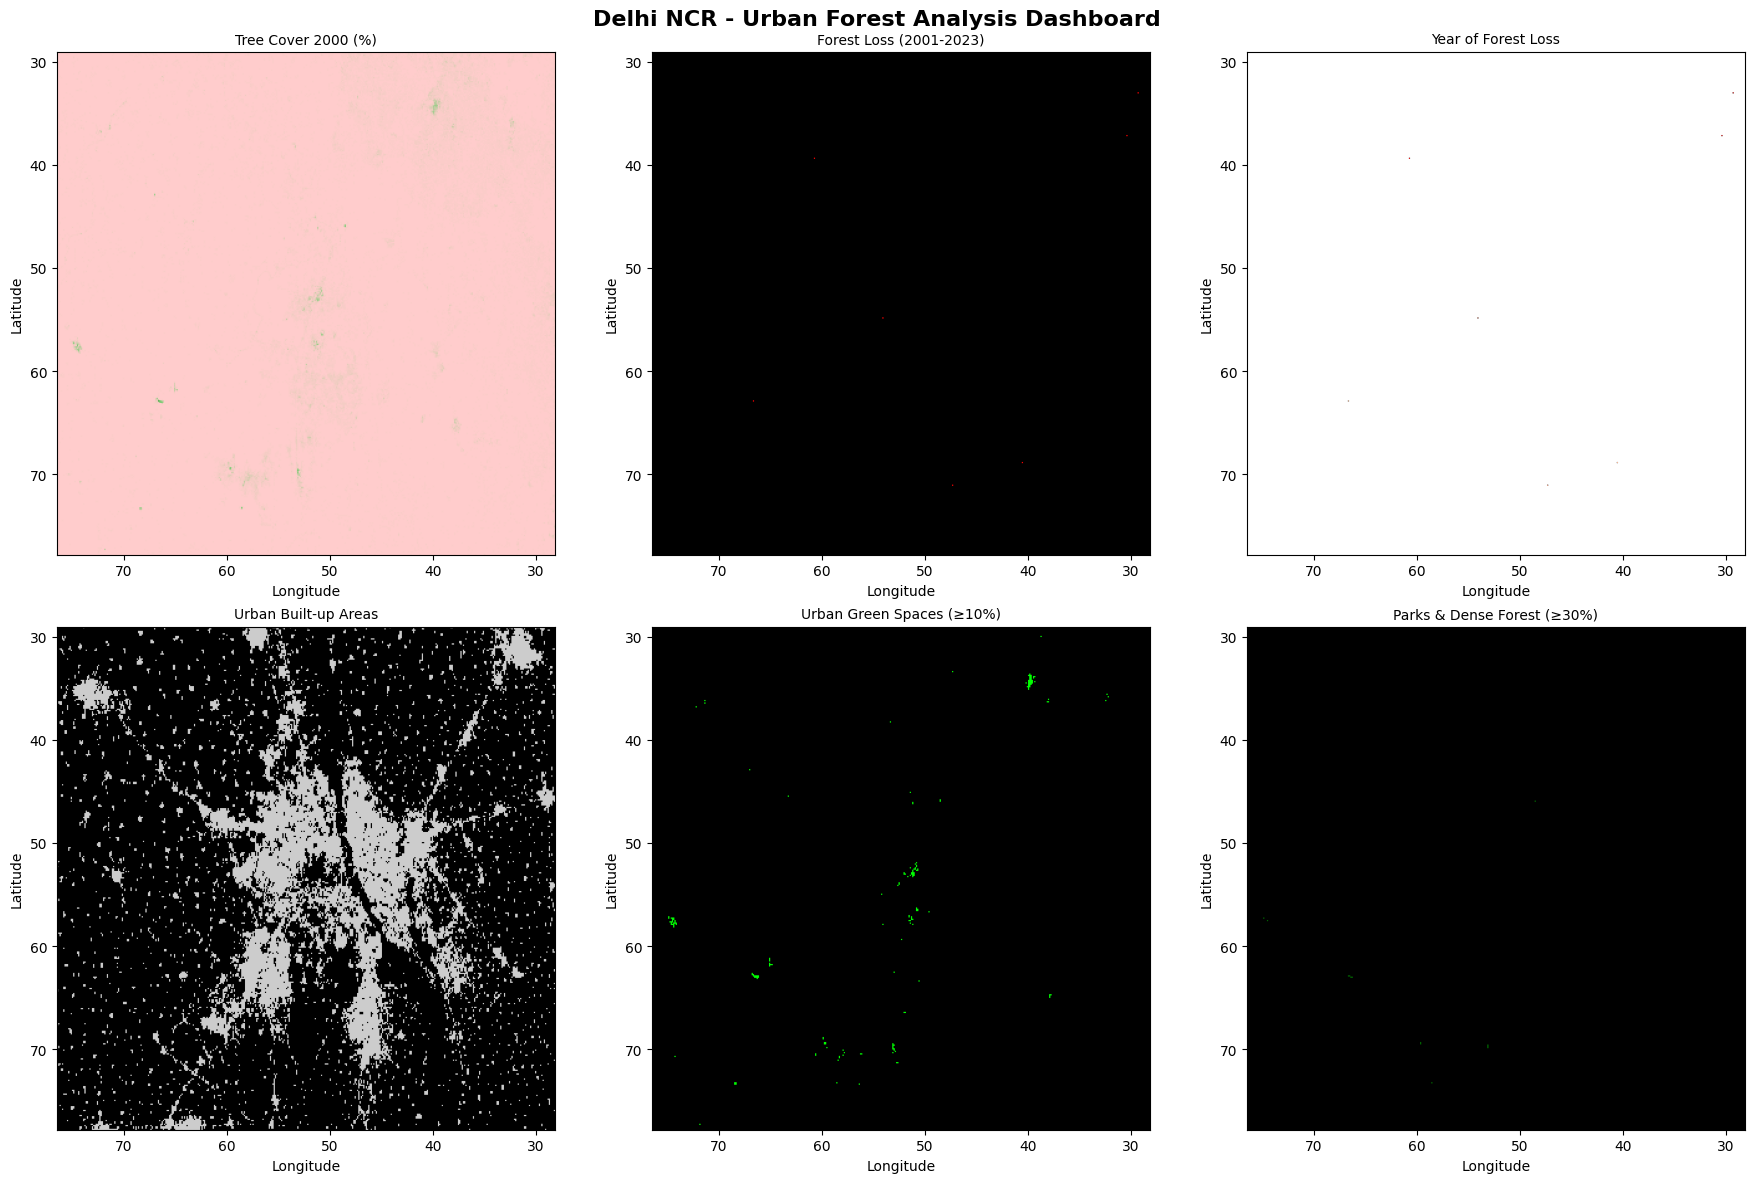

In [23]:
   delhi_results = analyze_delhi()


In [24]:
analyze_city_forest_cover('Mumbai')
analyze_city_forest_cover('Bangalore')


Loading forest and urban datasets for India...
ESA WorldCover dataset loaded (includes urban classification)
MODIS Land Cover dataset loaded
Landsat 8 dataset loaded for high-resolution analysis
Datasets ready for India analysis!

🌳 URBAN FOREST COVER: Mumbai
----------------------------------------
🏙️ Mumbai - Urban Forest Analysis:
  Total area: 1863.6 km²
  Urban green cover (≥10%): 128.2 km² (6.9%)
  Dense forest/parks (≥30%): 13.8 km² (0.7%)
  Average tree cover: 1.9%
  Population: ~21.0 million
  Green space per person: 6.1 m²
  WHO recommendation: 9 m²/person ❌
Loading forest and urban datasets for India...
ESA WorldCover dataset loaded (includes urban classification)
MODIS Land Cover dataset loaded
Landsat 8 dataset loaded for high-resolution analysis
Datasets ready for India analysis!

🌳 URBAN FOREST COVER: Bangalore
----------------------------------------
🏙️ Bangalore - Urban Forest Analysis:
  Total area: 1440.7 km²
  Urban green cover (≥10%): 2.9 km² (0.2%)
  Dense forest/

{'city_name': 'Bangalore',
 'total_area_km2': 1440.6551320539074,
 'urban_forest_km2': 2.9302950716107534,
 'urban_forest_pct': 0.20340017582369643,
 'dense_forest_km2': 0.1356290146484375,
 'dense_forest_pct': 0.009414398465722637,
 'mean_tree_cover': 0.07494338022620535,
 'green_per_person': 0.2254073132008272}

Loading forest and urban datasets for India...
ESA WorldCover dataset loaded (includes urban classification)
MODIS Land Cover dataset loaded
Landsat 8 dataset loaded for high-resolution analysis
Datasets ready for India analysis!

🏙️ INDIAN CITIES COMPARISON - FOREST_COVER

Analyzing Delhi NCR...

🌳 URBAN FOREST COVER: Delhi NCR
----------------------------------------
🏙️ Delhi NCR - Urban Forest Analysis:
  Total area: 3794.0 km²
  Urban green cover (≥10%): 11.4 km² (0.3%)
  Dense forest/parks (≥30%): 0.9 km² (0.0%)
  Average tree cover: 0.2%
  Population: ~32.0 million
  Green space per person: 0.4 m²
  WHO recommendation: 9 m²/person ❌

Analyzing Mumbai...

🌳 URBAN FOREST COVER: Mumbai
----------------------------------------
🏙️ Mumbai - Urban Forest Analysis:
  Total area: 1863.6 km²
  Urban green cover (≥10%): 128.2 km² (6.9%)
  Dense forest/parks (≥30%): 13.8 km² (0.7%)
  Average tree cover: 1.9%
  Population: ~21.0 million
  Green space per person: 6.1 m²
  WHO recommendation: 9

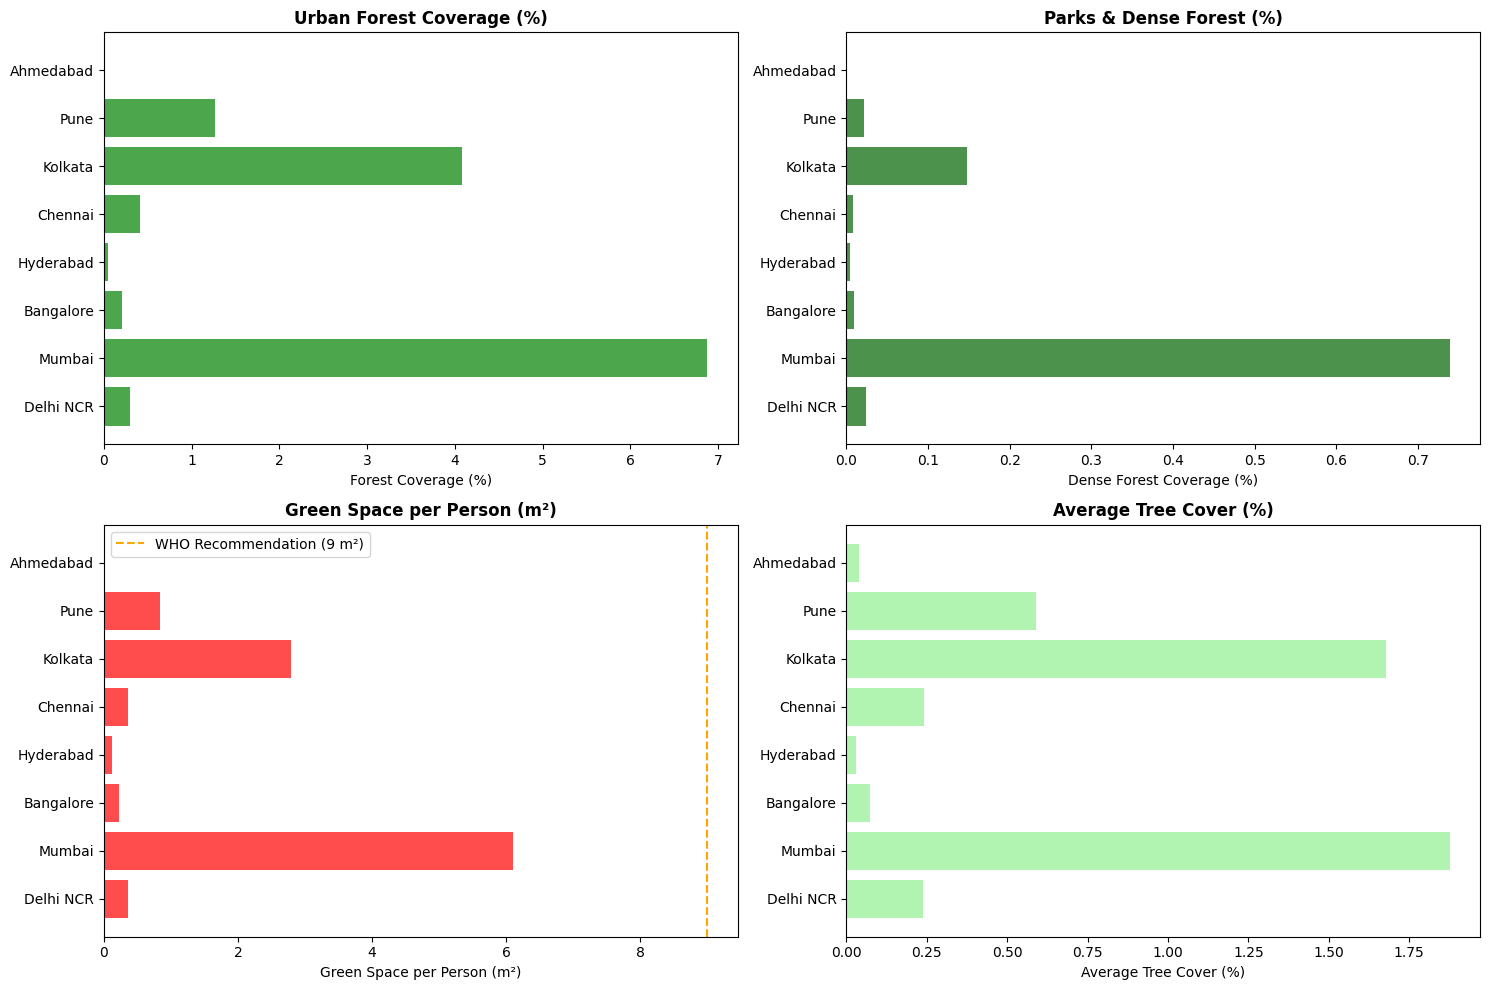

Loading forest and urban datasets for India...
ESA WorldCover dataset loaded (includes urban classification)
MODIS Land Cover dataset loaded
Landsat 8 dataset loaded for high-resolution analysis
Datasets ready for India analysis!

🏙️ INDIAN CITIES COMPARISON - DEFORESTATION

Analyzing Delhi NCR...

🔥 URBAN FOREST LOSS: Delhi NCR
----------------------------------------
📊 Forest Loss Analysis (2010-2023):
  Original forest area (2000): 11.4 km²
  Forest loss: 0.5 km² (4.3% of original)
  Annual loss rate: 0.31%/year
  Status: ✅ Low deforestation

Analyzing Mumbai...

🔥 URBAN FOREST LOSS: Mumbai
----------------------------------------
📊 Forest Loss Analysis (2010-2023):
  Original forest area (2000): 128.2 km²
  Forest loss: 0.1 km² (0.1% of original)
  Annual loss rate: 0.00%/year
  Status: ✅ Low deforestation

Analyzing Bangalore...

🔥 URBAN FOREST LOSS: Bangalore
----------------------------------------
📊 Forest Loss Analysis (2010-2023):
  Original forest area (2000): 2.9 km²
  Fore

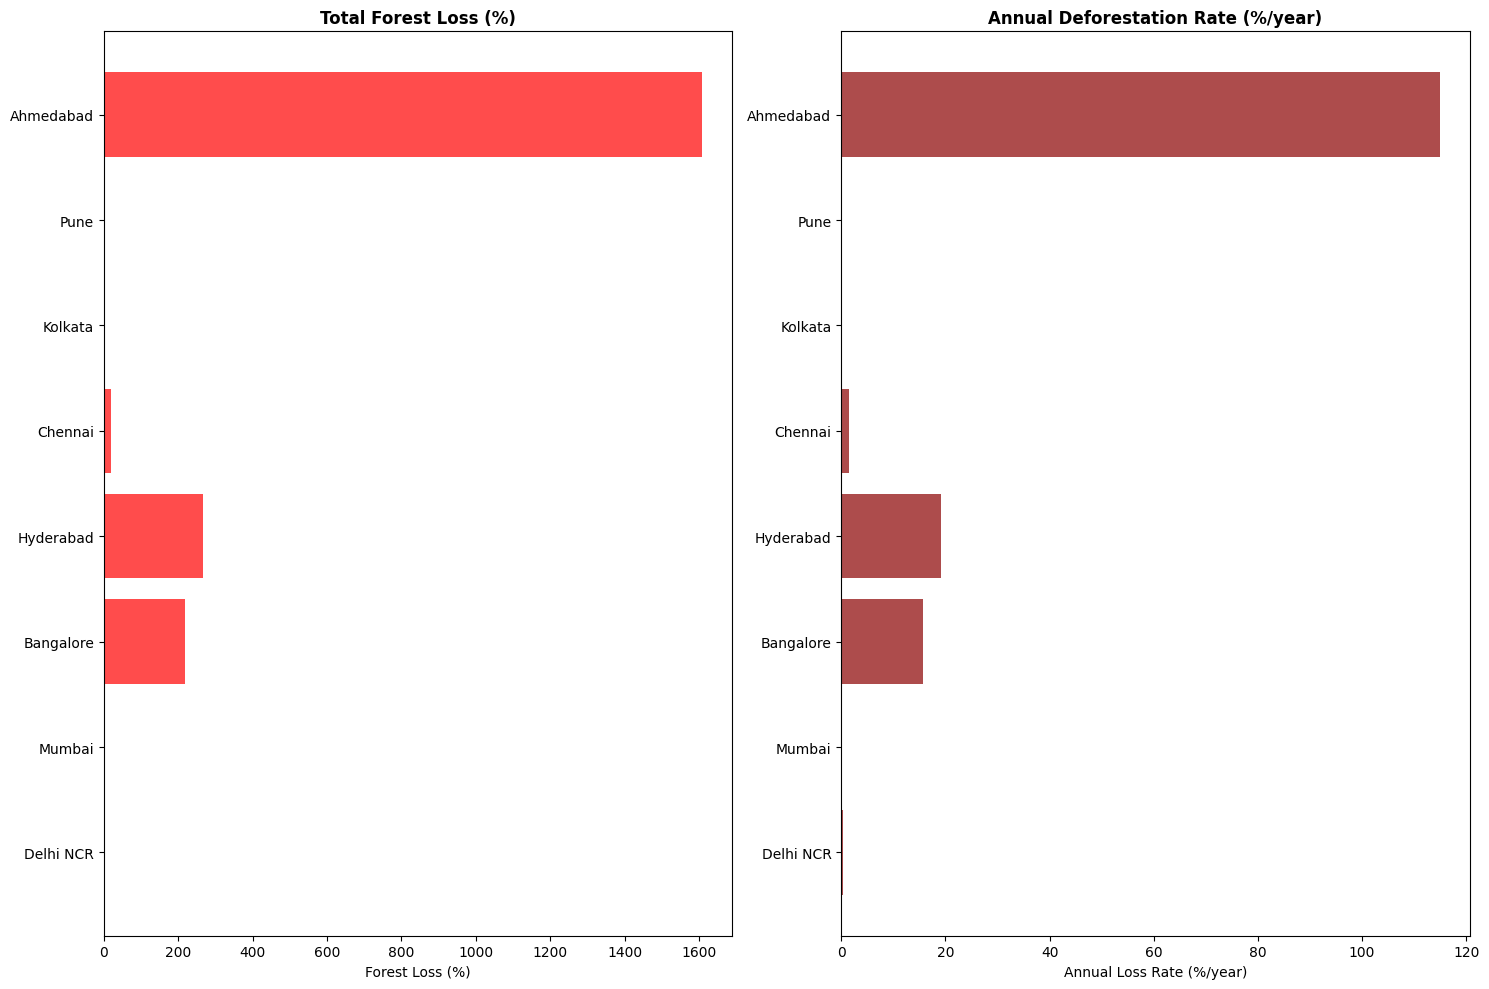

[{'city_name': 'Delhi NCR',
  'period': '2010-2023',
  'original_forest_km2': 11.382634992696843,
  'loss_km2': 0.4886292671645221,
  'loss_percentage': 4.292760573259436,
  'annual_rate': 0.3066257552328168,
  'status': '✅ Low deforestation',
  'bbox': [76.8, 28.4, 77.5, 28.9],
  'center': [77.2, 28.6],
  'population': '32 million',
  'description': 'National Capital Region including Delhi, Gurgaon, Noida'},
 {'city_name': 'Mumbai',
  'period': '2010-2023',
  'original_forest_km2': 128.18170321735204,
  'loss_km2': 0.065765177734375,
  'loss_percentage': 0.05130621304263675,
  'annual_rate': 0.0036647295030454823,
  'status': '✅ Low deforestation',
  'bbox': [72.7, 18.9, 73.1, 19.3],
  'center': [72.9, 19.1],
  'population': '21 million',
  'description': 'Financial capital, Maharashtra'},
 {'city_name': 'Bangalore',
  'period': '2010-2023',
  'original_forest_km2': 2.9302950716107534,
  'loss_km2': 6.421665174762562,
  'loss_percentage': 219.147390205746,
  'annual_rate': 15.65338501

In [26]:
compare_indian_cities('forest_cover')
compare_indian_cities('deforestation')

In [27]:
   analyze_urbanization_impact('Delhi NCR')


Loading forest and urban datasets for India...
ESA WorldCover dataset loaded (includes urban classification)
MODIS Land Cover dataset loaded
Landsat 8 dataset loaded for high-resolution analysis
Datasets ready for India analysis!

🏗️ URBANIZATION IMPACT: Delhi NCR
----------------------------------------
🏙️ Urban Development Analysis:
  Total area: 3797.7 km²
  Urban built-up area: 1257.6 km² (33.1%)
  Tree cover in urban areas: 0.1%
  Tree cover in non-urban areas: 0.3%
  Urban forest deficit: 0.2%


{'city_name': 'Delhi NCR',
 'urban_area_km2': 1257.6168042091672,
 'urban_percentage': 33.11538574695202,
 'urban_tree_cover': 0.08158443954606982,
 'non_urban_tree_cover': 0.31609343541753,
 'forest_deficit': 0.23450899587146018}